In [1]:
%pwd

'/home/ec2-user/SageMaker/projects/gnn/GNN-material/notebooks'

In [2]:
import torch
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import copy

sns.set_theme(style="white")

import sys
import os
# Make sure everything is on the path.
sys.path.insert(1, os.path.join(sys.path[0], '../src'))

from preprocess.build_drug_response_matrix import get_gdsc_gene_expression
from utils.global_vars import PlottingParameters

/home/ec2-user/anaconda3/envs/env280123/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%conda --version

usage: conda [-h] [-V] command ...
conda: error: unrecognized arguments: --version

Note: you may need to restart the kernel to use updated packages.


In this notebook we are going to create all the datasets.

Datasets used for the __drug response matrix__ (`../data/processed/drm_full.pkl`):
- `../data/raw/GDSC2_fitted_dose_response_25Feb20.xlsx`
- `../data/raw/GDSC1_fitted_dose_response_25Feb20.xlsx`
- `../data/raw/GDSC1_public_raw_data_25Feb20.csv`
- `../data/raw/GDSC2_public_raw_data_25Feb20.csv`

Datasets used for the __gene expression dataset__ (`../data/processed/gexpr_full.pkl`):
- `../data/raw/Cell_line_RMA_proc_basalExp.txt`
- `../data/raw/Cell_Lines_Details.xlsx`
- `../data/raw/landmark_genes.csv`
- `../data/processed/drm_full.pkl`

Datasets used for the __copy number picnic dataset__ (`../data/processed/cnvp_full.pkl`): 
- `../data/raw/cnv_abs_copy_number_picnic_20191101.csv`
- `../data/raw/landmark_genes.csv`
- `../data/processed/drm_full.pkl`

Datasets used for the __copy number gistic dataset__ (`../data/processed/cnvg_full.pkl`): 
- `../data/raw/cnv_gistic_20191101.csv`
- `../data/raw/landmark_genes.csv`
- `../data/processed/drm_full.pkl`


Datasets used for the __mutation dataset__ (`../data/processed/mut_full.pkl`): 
- `../data/raw/mutations_all_20220315.zip`
- `../data/raw/landmark_genes.csv`
- `../data/processed/drm_full.pkl`


In [4]:
RAW_DATA_PATH = '../../data/raw/'
PROCESSED_DATA_PATH = '../../data/processed/'

---

# Raw and Processed Datasets

## IC50's

In [4]:
GDSC1_IC50_FILE = 'GDSC1_fitted_dose_response_24Jul22.xlsx'
GDSC2_IC50_FILE = 'GDSC2_fitted_dose_response_24Jul22.xlsx'

# Read the IC50 files.
# GDSC1
start = time.time()
gdsc1_ic50s = pd.read_excel(f'{RAW_DATA_PATH}{GDSC1_IC50_FILE}', header=0)
print(f"File `{GDSC1_IC50_FILE}` took {time.time()-start:.5f} seconds to import. It has shape {gdsc1_ic50s.shape}")

# GDSC2
start = time.time()
gdsc2_ic50s = pd.read_excel(f'{RAW_DATA_PATH}{GDSC2_IC50_FILE}', header=0)
print(f"File `{GDSC2_IC50_FILE}` took {time.time()-start:.5f} seconds to import. It has shape {gdsc2_ic50s.shape}")

File `GDSC1_fitted_dose_response_24Jul22.xlsx` took 46.30528 seconds to import. It has shape (333161, 19)
File `GDSC2_fitted_dose_response_24Jul22.xlsx` took 33.31986 seconds to import. It has shape (242036, 19)


In [5]:
gdsc2_ic50s.head(3)

,DATASET,NLME_RESULT_ID,NLME_CURVE_ID,COSMIC_ID,CELL_LINE_NAME,SANGER_MODEL_ID,TCGA_DESC,DRUG_ID,DRUG_NAME,PUTATIVE_TARGET,PATHWAY_NAME,COMPANY_ID,WEBRELEASE,MIN_CONC,MAX_CONC,LN_IC50,AUC,RMSE,Z_SCORE
0,GDSC2,401,18945558,683667,PFSK-1,SIDM01132,MB,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.0001,0.1,-1.462148,0.930105,0.088999,0.432482
1,GDSC2,401,18945796,684052,A673,SIDM00848,UNCLASSIFIED,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.0001,0.1,-4.869447,0.614932,0.111423,-1.420322
2,GDSC2,401,18946078,684057,ES5,SIDM00263,UNCLASSIFIED,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.0001,0.1,-3.360684,0.790953,0.142754,-0.599894


## Raw data

In [7]:
GDSC1_RAW_FILE = 'GDSC1_public_raw_data_25Feb20.csv'
GDSC2_RAW_FILE = 'GDSC2_public_raw_data_25Feb20.csv'

# Read the raw files.
# GDSC1
start = time.time()
gdsc1_raw = pd.read_csv(f'{RAW_DATA_PATH}{GDSC1_RAW_FILE}', header=0)
print(f"File `{GDSC1_RAW_FILE}` took {time.time()-start:.5f} seconds to import. It has shape {gdsc1_raw.shape}")

# GDSC2
start = time.time()
gdsc2_raw = pd.read_csv(f'{RAW_DATA_PATH}{GDSC2_RAW_FILE}', header=0)
print(f"File `{GDSC2_RAW_FILE}` took {time.time()-start:.5f} seconds to import. It has shape {gdsc2_raw.shape}")

/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_10142/1587790020.py:7: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  gdsc1_raw = pd.read_csv(f'{RAW_DATA_PATH}{GDSC1_RAW_FILE}', header=0)


File `GDSC1_public_raw_data_25Feb20.csv` took 14.88413 seconds to import. It has shape (5837703, 18)
File `GDSC2_public_raw_data_25Feb20.csv` took 15.84662 seconds to import. It has shape (6646430, 18)


In [8]:
print(gdsc1_raw.head(3).to_markdown())
print()
print(gdsc2_raw.head(3).to_markdown())

|    | RESEARCH_PROJECT   |   BARCODE |   SCAN_ID | DATE_CREATED         |   SCAN_DATE |   CELL_ID |   MASTER_CELL_ID |   COSMIC_ID | CELL_LINE_NAME   |   SEEDING_DENSITY | DRUGSET_ID   | ASSAY   |   DURATION |   POSITION | TAG     |   DRUG_ID |   CONC |   INTENSITY |
|---:|:-------------------|----------:|----------:|:---------------------|------------:|----------:|-----------------:|------------:|:-----------------|------------------:|:-------------|:--------|-----------:|-----------:|:--------|----------:|-------:|------------:|
|  0 | Sanger_GDSC1       |    100541 |      1765 | 2010-04-18T23:00:00Z |         nan |      2415 |              365 |      924238 | K5               |               250 | 505_a_5      | a       |          3 |          1 | B       |       nan |    nan |       26022 |
|  1 | Sanger_GDSC1       |    100541 |      1765 | 2010-04-18T23:00:00Z |         nan |      2415 |              365 |      924238 | K5               |               250 | 505_a_5      | a    

In [9]:
# Join both datasets for analysis purposes.
gdsc_raw_join = pd.concat([gdsc1_raw, gdsc2_raw], ignore_index=True)
print(gdsc_raw_join.shape)
assert gdsc_raw_join[gdsc_raw_join.index.duplicated()].shape[0] == 0
assert gdsc_raw_join.shape[0] == gdsc1_raw.shape[0] + gdsc2_raw.shape[0]

(12484133, 18)


## Preprocess

In [6]:
print(gdsc2_ic50s.shape)
print(gdsc2_ic50s.columns)
gdsc2_ic50s.head(3)

(242036, 19)
Index(['DATASET', 'NLME_RESULT_ID', 'NLME_CURVE_ID', 'COSMIC_ID',
       'CELL_LINE_NAME', 'SANGER_MODEL_ID', 'TCGA_DESC', 'DRUG_ID',
       'DRUG_NAME', 'PUTATIVE_TARGET', 'PATHWAY_NAME', 'COMPANY_ID',
       'WEBRELEASE', 'MIN_CONC', 'MAX_CONC', 'LN_IC50', 'AUC', 'RMSE',
       'Z_SCORE'],
      dtype='object')


,DATASET,NLME_RESULT_ID,NLME_CURVE_ID,COSMIC_ID,CELL_LINE_NAME,SANGER_MODEL_ID,TCGA_DESC,DRUG_ID,DRUG_NAME,PUTATIVE_TARGET,PATHWAY_NAME,COMPANY_ID,WEBRELEASE,MIN_CONC,MAX_CONC,LN_IC50,AUC,RMSE,Z_SCORE
0,GDSC2,401,18945558,683667,PFSK-1,SIDM01132,MB,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.0001,0.1,-1.462148,0.930105,0.088999,0.432482
1,GDSC2,401,18945796,684052,A673,SIDM00848,UNCLASSIFIED,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.0001,0.1,-4.869447,0.614932,0.111423,-1.420322
2,GDSC2,401,18946078,684057,ES5,SIDM00263,UNCLASSIFIED,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.0001,0.1,-3.360684,0.790953,0.142754,-0.599894


In [7]:
COLS_TO_KEEP = ['DATASET', 'CELL_LINE_NAME', 'DRUG_NAME', 'DRUG_ID', 
                'SANGER_MODEL_ID', 'AUC', 'RMSE', 'Z_SCORE', 'LN_IC50']
gdsc_base = gdsc2_ic50s[COLS_TO_KEEP].drop_duplicates()
print(gdsc_base.shape)
# Percent of NaN values per column.
print("Missing rates:")
print("==============")
print(100 * gdsc_base.isna().sum() / gdsc_base.shape[0])
gdsc_base.head(3)

(242036, 9)
Missing rates:
DATASET            0.0
CELL_LINE_NAME     0.0
DRUG_NAME          0.0
DRUG_ID            0.0
SANGER_MODEL_ID    0.0
AUC                0.0
RMSE               0.0
Z_SCORE            0.0
LN_IC50            0.0
dtype: float64


,DATASET,CELL_LINE_NAME,DRUG_NAME,DRUG_ID,SANGER_MODEL_ID,AUC,RMSE,Z_SCORE,LN_IC50
0,GDSC2,PFSK-1,Camptothecin,1003,SIDM01132,0.930105,0.088999,0.432482,-1.462148
1,GDSC2,A673,Camptothecin,1003,SIDM00848,0.614932,0.111423,-1.420322,-4.869447
2,GDSC2,ES5,Camptothecin,1003,SIDM00263,0.790953,0.142754,-0.599894,-3.360684


In [8]:
# Occurence rate for each GDSC dataset.
round(100 * gdsc_base.DATASET.value_counts() / gdsc_base.shape[0])

GDSC2    100.0
Name: DATASET, dtype: float64

# Features

## Gene expression

In [10]:
cl_details = pd.read_excel(RAW_DATA_PATH + 'Cell_Lines_Details.xlsx')
print(cl_details.shape)
cl_details.head(3)

(1002, 13)


/home/ec2-user/anaconda3/envs/env2803/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Sample Name,COSMIC identifier,Whole Exome Sequencing (WES),Copy Number Alterations (CNA),Gene Expression,Methylation,Drug\nResponse,GDSC\nTissue descriptor 1,GDSC\nTissue\ndescriptor 2,Cancer Type\n(matching TCGA label),Microsatellite \ninstability Status (MSI),Screen Medium,Growth Properties
0,A253,906794.0,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,NaN,MSS/MSI-L,D/F12,Adherent
1,BB30-HNC,753531.0,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent
2,BB49-HNC,753532.0,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent


In [11]:
gene_expression = pd.read_csv(RAW_DATA_PATH + 'Cell_line_RMA_proc_basalExp.txt', sep="\t")
print(gene_expression.shape)
gene_expression.iloc[:2, :10]

(17737, 1020)


,GENE_SYMBOLS,GENE_title,DATA.906826,DATA.687983,DATA.910927,DATA.1240138,DATA.1240139,DATA.906792,DATA.910688,DATA.1240135
0,TSPAN6,tetraspanin 6 [Source:HGNC Symbol;Acc:11858],7.632023,7.548671,8.712338,7.797142,7.729268,7.074533,3.285198,6.961606
1,TNMD,tenomodulin [Source:HGNC Symbol;Acc:17757],2.964585,2.777716,2.643508,2.817923,2.957739,2.889677,2.828203,2.874751


In [13]:
# from src.preprocess.build_drug_response_matrix import (
#     get_gdsc_gene_expression, cosmic_ids_to_cell_line_names
# )

CELL_LINE_DETAILS_FILE = 'Cell_Lines_Details.xlsx'
GENE_EXPRESSION_RAW_FILE = 'Cell_line_RMA_proc_basalExp.txt'

# Return the gene expression dataframe(n_cells x n_genes) for a set of gene symbols for all 
# cell_lines of the GDSC cell line annotation file.
# If the genes are None, return the data for all genes.
gene_expr = get_gdsc_gene_expression(
    path_cell_annotations=RAW_DATA_PATH + CELL_LINE_DETAILS_FILE,
    path_gene_expression=RAW_DATA_PATH + GENE_EXPRESSION_RAW_FILE 
)
print(gene_expr.shape)
gene_expr.head(3)

Note: 50 Cosmic IDs not found in cell annotation data: 
['906815', '1330955', '907284', '1330944', '1330943', '1298232', '1299076', '1299051', '906829', '1290773', '907049', '909730', '910946', '907391', '687509', '1327761', '753536', '1240152', '925342', '687814', '1479994', '1479991', '1298355', '1331026', '1298150', '1479993', '11223344', '1330945', '1479992', '998179', '1331060', '1331028', '1503362.1', '906850', '1240211', '1299049', '908119', '1331031', '907785', '1330983.1', '906867', '1723793', '1723794', '1240156', '1299067', '906803', '1298154', '909976.1', '1659787', '905954.1']
(1018, 17737)


/home/ec2-user/anaconda3/envs/env2803/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


Sample Name,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,LINC00526,PPY2,nan,nan,KRT18P55,nan,POLRMTP1,UBL5P2,TBC1D3P5,nan
CAL-120,7.632023,2.964585,10.379553,3.614794,3.380681,3.324692,3.566350,8.204530,5.235118,5.369039,...,6.786925,2.997054,3.109774,7.882377,3.331134,2.852537,3.130696,9.986616,3.073724,7.284733
DMS-114,7.548671,2.777716,11.807341,4.066887,3.732485,3.152404,7.827172,6.616972,5.809264,7.209653,...,5.317911,3.263745,3.059424,8.681302,2.992611,2.776771,3.260982,9.002814,3.000182,8.504804
CAL-51,8.712338,2.643508,9.880733,3.956230,3.236620,3.241246,2.931034,8.191246,5.426841,5.120747,...,3.143006,3.112145,2.930254,8.707886,2.886574,2.685307,3.176239,9.113243,2.916274,7.059092


In [14]:
LANDMARK_GENES_FILE = 'landmark_genes.csv' 

landmark_genes = pd.read_csv(RAW_DATA_PATH + LANDMARK_GENES_FILE, sep="\t")
print(landmark_genes.shape)
landmark_genes.head(3)

(978, 7)


,Entrez ID,Symbol,Name,Gene Family,Type,RNA-Seq Correlation,RNA-Seq Correlation Self-Rank
0,3638,INSIG1,insulin induced gene 1,NaN,landmark,NaN,NaN
1,2309,FOXO3,forkhead box O3,Forkhead boxes,landmark,NaN,NaN
2,1001,CDH3,cadherin 3,Type I classical cadherins,landmark,NaN,NaN


In [15]:
# Choose only the cell-line columns of the gene expressions table that are in the landmark gene file.
inter_cols = list(set(gene_expr.columns).intersection(set(landmark_genes.Symbol)))
gene_expr_sparse = gene_expr[inter_cols]
gene_expr_sparse.columns.rename('CELL_LINE_NAME', inplace=True)
print(gene_expr_sparse.shape)
gene_expr_sparse.head(3)

(1018, 908)


CELL_LINE_NAME,CASP7,RSU1,DUSP6,CCDC86,HSD17B10,MRPL19,USP7,CCNF,PPOX,CCNA1,...,EVL,TRAM2,MTHFD2,KDM5A,IGHMBP2,PPIE,PIGB,NOTCH1,NOLC1,TM9SF2
CAL-120,4.000250,8.369014,5.972405,7.006223,8.840328,9.854163,6.829879,5.636602,5.448698,4.335186,...,4.749416,6.999620,10.503522,6.926604,4.956722,8.183743,6.010790,3.189415,6.796565,8.797316
DMS-114,6.479213,9.685341,10.198164,7.569609,10.465719,10.905396,6.996416,5.911590,7.116901,2.762622,...,5.807871,5.851882,10.932909,7.365255,8.260318,9.376689,6.094144,3.174291,8.258066,9.171954
CAL-51,4.829841,8.332596,9.608487,6.811814,8.902116,9.996235,7.088065,5.180033,5.356761,2.841240,...,4.684272,5.782095,10.989534,6.147986,4.566837,8.112610,6.163356,3.671769,7.076569,9.278233


In [16]:
gdsc_base = pd.read_pickle(PROCESSED_DATA_PATH + 'drm_full.pkl')

cols_to_join_on = ['CELL_LINE_NAME']
join_gdsc_geneexpr = gdsc_base.merge(right=gene_expr_sparse,
                                     left_on=['CELL_LINE_NAME'],
                                     right_index=True,
                                     how='left',
                                     suffixes=['_gdsc', '_geneexpr'])
print(join_gdsc_geneexpr.shape)
join_gdsc_geneexpr.head(3)

(575197, 917)


,DATASET,CELL_LINE_NAME,DRUG_NAME,DRUG_ID,SANGER_MODEL_ID,AUC,RMSE,Z_SCORE,LN_IC50,CASP7,...,EVL,TRAM2,MTHFD2,KDM5A,IGHMBP2,PPIE,PIGB,NOTCH1,NOLC1,TM9SF2
0,GDSC1,ES5,Erlotinib,1,SIDM00263,0.985678,0.026081,1.299144,3.966813,5.030278,...,5.727032,5.384681,10.170706,7.540468,4.820631,9.289216,6.730016,3.490747,6.380986,9.290733
1,GDSC1,ES7,Erlotinib,1,SIDM00269,0.972690,0.110059,0.156076,2.692090,5.900748,...,5.631510,4.380289,11.169088,6.923216,4.750593,8.230248,5.594229,3.575965,7.274334,7.549911
2,GDSC1,EW-11,Erlotinib,1,SIDM00203,0.944459,0.087019,-0.035912,2.477990,5.534147,...,6.518258,4.492482,9.753489,6.738176,5.479187,8.774436,4.103147,3.709078,7.078668,9.056814


## Copy number variation - picnic

In [17]:
start = time.time()
cnv_picnic_v0 = pd.read_csv(RAW_DATA_PATH + 'cnv_abs_copy_number_picnic_20191101.csv', sep=",", header=1)
cnv_picnic_v0.rename(columns={
    'Unnamed: 1': 'GENE_SYMBOL',
    'model_name': 'GENE_ID'}, inplace=True)
cnv_picnic_v0 = cnv_picnic_v0.iloc[1:, :]
print(f"File `cnv_abs_copy_number_picnic_20191101.csv` took {time.time()-start:.5f} seconds to import. \nShape: {cnv_picnic_v0.shape}")
cnv_picnic_v0.head(3)

File `cnv_abs_copy_number_picnic_20191101.csv` took 22.09094 seconds to import. 
Shape: (24502, 988)


,GENE_ID,GENE_SYMBOL,M14,TE-12,TMK-1,STS-0421,PL4,PCI-4B,PCI-30,HSC-39,...,451Lu,MMAc-SF,BE-13,MC-IXC,Ramos-2G6-4C10,CGTH-W-1,H9,GR-ST,YMB-1-E,MM1S
1,SIDG00001,A1BG,3.0,3.0,3.0,4.0,6.0,3.0,2.0,3.0,...,4.0,3.0,4.0,2.0,2.0,4.0,4.0,2.0,3.0,2.0
2,SIDG00003,A1CF,3.0,3.0,3.0,4.0,3.0,3.0,3.0,3.0,...,4.0,2.0,3.0,1.0,2.0,3.0,4.0,2.0,3.0,2.0
3,SIDG00004,A2M,3.0,3.0,2.0,4.0,9.0,3.0,3.0,3.0,...,5.0,3.0,4.0,2.0,2.0,4.0,3.0,2.0,5.0,2.0


In [18]:
cnv_picnic_v0.iloc[:3, :10]

,GENE_ID,GENE_SYMBOL,M14,TE-12,TMK-1,STS-0421,PL4,PCI-4B,PCI-30,HSC-39
1,SIDG00001,A1BG,3.0,3.0,3.0,4.0,6.0,3.0,2.0,3.0
2,SIDG00003,A1CF,3.0,3.0,3.0,4.0,3.0,3.0,3.0,3.0
3,SIDG00004,A2M,3.0,3.0,2.0,4.0,9.0,3.0,3.0,3.0


Note that here the columns are the cell-line names and the row are indentified by the genes.

In [19]:
cnv_picnic_v1 = cnv_picnic_v0.iloc[:, 1:].T
cnv_picnic_v1 = cnv_picnic_v1.rename(columns=cnv_picnic_v1.iloc[0]).drop(cnv_picnic_v1.index[0])
print(cnv_picnic_v1.shape)
cnv_picnic_v1.head(3)

(986, 24502)


,A1BG,A1CF,A2M,A2ML1,A2ML1-AS1,A2ML1-AS2,A3GALT2,A4GALT,A4GNT,AAAS,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11AP1,ZYG11B,ZYX,ZZEF1,ZZZ3
M14,3.0,3.0,3.0,3.0,3.0,3.0,4.0,4.0,4.0,3.0,...,3.0,2.0,2.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0
TE-12,3.0,3.0,3.0,3.0,3.0,3.0,2.0,3.0,3.0,3.0,...,3.0,2.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
TMK-1,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0,...,3.0,2.0,2.0,1.0,3.0,3.0,3.0,3.0,2.0,3.0


In [20]:
# ------------------------------------------------------------------- #
# Sparse down the gene column dimension by only using landmark genes. #
# ------------------------------------------------------------------- #
LANDMARK_GENES_FILE = 'landmark_genes.csv' 

landmark_genes = pd.read_csv(RAW_DATA_PATH + LANDMARK_GENES_FILE, sep="\t")
print(landmark_genes.shape)

# Check how many cell line columns of the cnv picnic table are in the landmark gene file.
count, cols_to_keep = 0, []
for c in cnv_picnic_v1.columns[cnv_picnic_v1.columns != 'nan']:
    if c in landmark_genes.Symbol.tolist(): 
        count += 1
        cols_to_keep.append(c)

cnv_picnic_v2 = cnv_picnic_v1[cols_to_keep]
assert cnv_picnic_v2.shape[1] == len(cols_to_keep)
print(cnv_picnic_v2.shape)
cnv_picnic_v2.head(3)

(978, 7)
(986, 966)


,AARS,ABCB6,ABCC5,ABCF1,ABCF3,ABHD4,ABHD6,ABL1,ACAA1,ACAT2,...,ZMIZ1,ZMYM2,ZNF131,ZNF274,ZNF318,ZNF395,ZNF451,ZNF586,ZNF589,ZW10
M14,3.0,3.0,4.0,3.0,4.0,2.0,3.0,3.0,3.0,2.0,...,3.0,3.0,3.0,3.0,3.0,2.0,3.0,3.0,3.0,3.0
TE-12,4.0,3.0,3.0,2.0,3.0,4.0,2.0,4.0,2.0,2.0,...,3.0,4.0,5.0,3.0,2.0,3.0,2.0,3.0,2.0,3.0
TMK-1,3.0,2.0,3.0,3.0,3.0,3.0,2.0,3.0,2.0,2.0,...,2.0,2.0,5.0,3.0,3.0,2.0,3.0,3.0,2.0,4.0


In [21]:
gdsc_base = pd.read_pickle(PROCESSED_DATA_PATH + 'drm_full.pkl')

# Join the sparsed CNV data to the GDSC table.
cols_to_join_on = ['CELL_LINE_NAME']
join_gdsc_cnv_picnic = gdsc_base.merge(right=cnv_picnic_v2,
                                       left_on=['CELL_LINE_NAME'],
                                       right_index=True,
                                       how='left',
                                       suffixes=['_gdsc', '_cnvp'])
print(join_gdsc_cnv_picnic.shape)
join_gdsc_cnv_picnic.head(3)

(575197, 975)


,DATASET,CELL_LINE_NAME,DRUG_NAME,DRUG_ID,SANGER_MODEL_ID,AUC,RMSE,Z_SCORE,LN_IC50,AARS,...,ZMIZ1,ZMYM2,ZNF131,ZNF274,ZNF318,ZNF395,ZNF451,ZNF586,ZNF589,ZW10
0,GDSC1,ES5,Erlotinib,1,SIDM00263,0.985678,0.026081,1.299144,3.966813,3.0,...,2.0,3.0,3.0,3.0,4.0,6.0,4.0,3.0,4.0,3.0
1,GDSC1,ES7,Erlotinib,1,SIDM00269,0.972690,0.110059,0.156076,2.692090,3.0,...,3.0,4.0,4.0,3.0,4.0,3.0,4.0,3.0,3.0,2.0
2,GDSC1,EW-11,Erlotinib,1,SIDM00203,0.944459,0.087019,-0.035912,2.477990,3.0,...,2.0,3.0,5.0,3.0,4.0,5.0,4.0,3.0,3.0,4.0


## Copy number variation - gistic

In [22]:
start = time.time()
cnv_gistic_v0 = pd.read_csv(RAW_DATA_PATH + 'cnv_gistic_20191101.csv', sep=",", header=1)
cnv_gistic_v0.rename(columns={
    'Unnamed: 1': 'GENE_SYMBOL',
    'model_name': 'GENE_ID'}, inplace=True)
cnv_gistic_v0 = cnv_gistic_v0.iloc[1:, :]
print(f"File `cnv_gistic_20191101.csv` took {time.time()-start:.5f} seconds to import. \nShape: {cnv_gistic_v0.shape}")
cnv_gistic_v0.head(3)

File `cnv_gistic_20191101.csv` took 20.24881 seconds to import. 
Shape: (20669, 980)


,GENE_ID,GENE_SYMBOL,M14,TE-12,TMK-1,STS-0421,PL4,PCI-4B,PCI-30,HSC-39,...,451Lu,MMAc-SF,BE-13,MC-IXC,Ramos-2G6-4C10,CGTH-W-1,H9,GR-ST,YMB-1-E,MM1S
1,SIDG00001,A1BG,0.0,-1.0,0.0,0.0,1.0,-1.0,0.0,0.0,...,0.0,-1.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,SIDG00002,A1BG-AS1,0.0,-1.0,0.0,0.0,1.0,-1.0,0.0,0.0,...,0.0,-1.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,SIDG00003,A1CF,-1.0,0.0,0.0,1.0,-1.0,0.0,1.0,0.0,...,0.0,-1.0,-1.0,-1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [23]:
cnv_gistic_v0.iloc[:3, :10]

,GENE_ID,GENE_SYMBOL,M14,TE-12,TMK-1,STS-0421,PL4,PCI-4B,PCI-30,HSC-39
1,SIDG00001,A1BG,0.0,-1.0,0.0,0.0,1.0,-1.0,0.0,0.0
2,SIDG00002,A1BG-AS1,0.0,-1.0,0.0,0.0,1.0,-1.0,0.0,0.0
3,SIDG00003,A1CF,-1.0,0.0,0.0,1.0,-1.0,0.0,1.0,0.0


Note that here the columns are the cell-line names and the row are indentified by the genes.

In [24]:
cnv_gistic_v1 = cnv_gistic_v0.iloc[:, 1:].T
cnv_gistic_v1 = cnv_gistic_v1.rename(columns=cnv_gistic_v1.iloc[0]).drop(cnv_gistic_v1.index[0])
print(cnv_gistic_v1.shape)
cnv_gistic_v1.head(3)

(978, 20669)


,A1BG,A1BG-AS1,A1CF,A2M,A2ML1,A2MP1,A4GALT,A4GNT,AAAS,AACS,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
M14,0.0,0.0,-1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,-1.0,0.0,1.0,-1.0,1.0,1.0,1.0,2.0,2.0,2.0
TE-12,-1.0,-1.0,0.0,1.0,1.0,1.0,-1.0,0.0,0.0,0.0,...,-1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
TMK-1,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,...,-1.0,1.0,0.0,1.0,-2.0,0.0,0.0,2.0,-1.0,1.0


In [25]:
# ------------------------------------------------------------------- #
# Sparse down the gene column dimension by only using landmark genes. #
# ------------------------------------------------------------------- #
LANDMARK_GENES_FILE = 'landmark_genes.csv' 

landmark_genes = pd.read_csv(RAW_DATA_PATH + LANDMARK_GENES_FILE, sep="\t")
print(landmark_genes.shape)

# Check how many cell line columns of the cnv picnic table are in the landmark gene file.
count, cols_to_keep = 0, []
for c in cnv_gistic_v1.columns[cnv_gistic_v1.columns != 'nan']:
    if c in landmark_genes.Symbol.tolist(): 
        count += 1
        cols_to_keep.append(c)

cnv_gistic_v2 = cnv_gistic_v1[cols_to_keep]
assert cnv_gistic_v2.shape[1] == len(cols_to_keep)
print(cnv_gistic_v2.shape)
cnv_gistic_v2.head(3)

(978, 7)
(978, 938)


,AARS,ABCB6,ABCC5,ABCF1,ABCF3,ABHD4,ABHD6,ABL1,ACAA1,ACAT2,...,ZMIZ1,ZMYM2,ZNF131,ZNF274,ZNF318,ZNF395,ZNF451,ZNF586,ZNF589,ZW10
M14,0.0,0.0,1.0,0.0,1.0,-1.0,0.0,0.0,0.0,-1.0,...,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0
TE-12,1.0,-1.0,0.0,-1.0,0.0,1.0,-1.0,1.0,-1.0,-1.0,...,-1.0,1.0,1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,1.0
TMK-1,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,-1.0,...,-1.0,-1.0,1.0,0.0,0.0,-1.0,1.0,0.0,-1.0,1.0


In [26]:
gdsc_base = pd.read_pickle(PROCESSED_DATA_PATH + 'drm_full.pkl')

# Join the sparsed CNV data to the GDSC table.
cols_to_join_on = ['CELL_LINE_NAME']
join_gdsc_cnv_gistic = gdsc_base.merge(right=cnv_gistic_v2,
                                       left_on=['CELL_LINE_NAME'],
                                       right_index=True,
                                       how='left',
                                       suffixes=['_gdsc', '_cnvg'])
print(join_gdsc_cnv_gistic.shape)
join_gdsc_cnv_gistic.head(3)

(575197, 947)


,DATASET,CELL_LINE_NAME,DRUG_NAME,DRUG_ID,SANGER_MODEL_ID,AUC,RMSE,Z_SCORE,LN_IC50,AARS,...,ZMIZ1,ZMYM2,ZNF131,ZNF274,ZNF318,ZNF395,ZNF451,ZNF586,ZNF589,ZW10
0,GDSC1,ES5,Erlotinib,1,SIDM00263,0.985678,0.026081,1.299144,3.966813,-1.0,...,-1.0,-1.0,-1.0,-1.0,0.0,1.0,1.0,-1.0,0.0,-1.0
1,GDSC1,ES7,Erlotinib,1,SIDM00269,0.972690,0.110059,0.156076,2.692090,0.0,...,-1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,-1.0,-1.0
2,GDSC1,EW-11,Erlotinib,1,SIDM00203,0.944459,0.087019,-0.035912,2.477990,-1.0,...,-1.0,-1.0,1.0,-1.0,0.0,1.0,0.0,-1.0,-1.0,0.0


## Mutation

In [42]:
start = time.time()
mutations_v0 = pd.read_csv(RAW_DATA_PATH + 'mutations_all_20220315.csv', sep=",", header=0)
print(f"File `mutations_all_20220315.csv` took {time.time()-start:.5f} seconds to import. \nShape: {mutations_v0.shape}")
mutations_v0.head(5)

File `mutations_all_20220315.csv` took 13.46986 seconds to import. 
Shape: (8322616, 13)


,gene_id,gene_symbol,model_id,protein_mutation,rna_mutation,cdna_mutation,cancer_driver,cancer_predisposition_variant,effect,vaf,coding,source,model_name
0,SIDG36104,SOX30,SIDM02021,-,r.?,-,False,False,intronic,0.2703,False,Sanger,HCM-SANG-1082-C15
1,SIDG37647,THG1L,SIDM02021,-,r.?,-,False,False,intronic,0.7500,False,Sanger,HCM-SANG-1082-C15
2,SIDG16920,LSM11,SIDM02021,-,r.?,-,False,False,intronic,0.6452,False,Sanger,HCM-SANG-1082-C15
3,SIDG16920,LSM11,SIDM02021,p.?,r.3207delU,c.?,False,False,3prime_UTR_variant,0.7692,False,Sanger,HCM-SANG-1082-C15
4,SIDG16920,LSM11,SIDM02021,-,r.?,-,False,False,downstream,0.3571,False,Sanger,HCM-SANG-1082-C15


In [43]:
gdsc_base = pd.read_pickle(PROCESSED_DATA_PATH + 'drm_full.pkl')

# Find the CELL_LINE_NAME's per SANGER_MODEL_ID.
celllines_per_sangermodelid = gdsc_base[['SANGER_MODEL_ID', 'CELL_LINE_NAME']].groupby('SANGER_MODEL_ID')['CELL_LINE_NAME'].nunique()
counts_per_sangermodelid = celllines_per_sangermodelid.values

assert (counts_per_sangermodelid != 1).any() == False
assert (counts_per_sangermodelid == 1).all()

# Only take the interested columns for the mapping.
gdsc_mapping_subset = gdsc_base[['SANGER_MODEL_ID', 'CELL_LINE_NAME']]

# Only take the unique SANGER_MODEL_ID's, since these have a 1-to-1 relationship to the CELL_LINE_NAME's anyways.
gdsc_mapping_subset = gdsc_mapping_subset.groupby('SANGER_MODEL_ID').first().reset_index(level=0)

# Join the CELL_LINE_NAME's onto the mutations_all dataset, based on the model_id.
mutations_v1 = mutations_v0.merge(right=gdsc_mapping_subset,
                                  left_on='model_id',
                                  right_on='SANGER_MODEL_ID',
                                  how='left')
print("We joined the mutations dataset with the GDSC table to get the SANGER_MODEL_ID & CELL_LINE_NAME for each row in the mutations dataset.")                                  
print(f"Shape: {mutations_v1.shape}")
mutations_v1.head(5)

We joined the mutations dataset with the GDSC table to get the SANGER_MODEL_ID & CELL_LINE_NAME for each row in the mutations dataset.
Shape: (8322616, 15)


,gene_id,gene_symbol,model_id,protein_mutation,rna_mutation,cdna_mutation,cancer_driver,cancer_predisposition_variant,effect,vaf,coding,source,model_name,SANGER_MODEL_ID,CELL_LINE_NAME
0,SIDG36104,SOX30,SIDM02021,-,r.?,-,False,False,intronic,0.2703,False,Sanger,HCM-SANG-1082-C15,NaN,NaN
1,SIDG37647,THG1L,SIDM02021,-,r.?,-,False,False,intronic,0.7500,False,Sanger,HCM-SANG-1082-C15,NaN,NaN
2,SIDG16920,LSM11,SIDM02021,-,r.?,-,False,False,intronic,0.6452,False,Sanger,HCM-SANG-1082-C15,NaN,NaN
3,SIDG16920,LSM11,SIDM02021,p.?,r.3207delU,c.?,False,False,3prime_UTR_variant,0.7692,False,Sanger,HCM-SANG-1082-C15,NaN,NaN
4,SIDG16920,LSM11,SIDM02021,-,r.?,-,False,False,downstream,0.3571,False,Sanger,HCM-SANG-1082-C15,NaN,NaN


Note: Each `CELL_LINE_NAME` has only exactly one `SANGER_MODEL_ID`.

In [44]:
 # Only taking the ones with a CELL_LINE_NAME.
mutations_v2 = mutations_v1[mutations_v1['CELL_LINE_NAME'].notna()]
print("We excluded all rows which have CELL_LINE_NAME as NaN.")
print(f"Number of unique `gene_symbol`s in the mutations dataset: {len(np.unique(mutations_v2.gene_symbol))}")
print(f"Shape: {mutations_v2.shape}")
mutations_v2.head(5)

We excluded all rows which have CELL_LINE_NAME as NaN.
Number of unique `gene_symbol`s in the mutations dataset: 20448
Shape: (4554297, 15)


,gene_id,gene_symbol,model_id,protein_mutation,rna_mutation,cdna_mutation,cancer_driver,cancer_predisposition_variant,effect,vaf,coding,source,model_name,SANGER_MODEL_ID,CELL_LINE_NAME
19,SIDG40054,UAP1,SIDM00615,-,r.?,-,False,False,intronic,0.2857,False,Sanger,JHH-6,SIDM00615,JHH-6
20,SIDG13175,IPO11,SIDM01119,-,r.?,-,False,False,intronic,0.3511,False,Sanger,NCI-H727,SIDM01119,NCI-H727
21,SIDG14638,LIN9,SIDM00933,-,r.?,-,False,False,downstream,1.0000,False,Sanger,CAL-51,SIDM00933,CAL-51
22,SIDG07173,DYM,SIDM00933,-,r.?,-,False,False,intronic,0.5294,False,Sanger,CAL-51,SIDM00933,CAL-51
23,SIDG08926,FCAMR,SIDM00620,-,r.?,-,False,False,intronic,0.6250,False,Sanger,D-336MG,SIDM00620,D-336MG


In [45]:
LANDMARK_GENES_FILE = 'landmark_genes.csv' 

landmark_genes = pd.read_csv(RAW_DATA_PATH + LANDMARK_GENES_FILE, sep="\t")
print("We use the landmark genes to sparse down the dimension.")

# Take only the rows which have a `gene_symbol` which is also present in the landmark genes table.
mutations_v3 = mutations_v2.merge(right=landmark_genes['Symbol'],
                                  left_on='gene_symbol',
                                  right_on='Symbol')
print("We merged the most recent dataset mutations_v2 with the landmark genes to sparse it down.")                                  
print(f"Shape: {mutations_v3.shape}")
mutations_v3.head(3)  

We use the landmark genes to sparse down the dimension.
We merged the most recent dataset mutations_v2 with the landmark genes to sparse it down.
Shape: (234872, 16)


,gene_id,gene_symbol,model_id,protein_mutation,rna_mutation,cdna_mutation,cancer_driver,cancer_predisposition_variant,effect,vaf,coding,source,model_name,SANGER_MODEL_ID,CELL_LINE_NAME,Symbol
0,SIDG40702,VGLL4,SIDM00330,-,r.?,-,False,False,intronic,0.9926,False,Sanger,LAN-6,SIDM00330,LAN-6,VGLL4
1,SIDG40702,VGLL4,SIDM00944,p.?,r.407-7c>u,c.?,False,False,splice_region,0.6190,False,Broad,CL-11,SIDM00944,CL-11,VGLL4
2,SIDG40702,VGLL4,SIDM00373,p.?,r.65c>u,c.?,False,False,5prime_UTR_variant,0.4118,False,Broad,SNG-M,SIDM00373,SNG-M,VGLL4


In [46]:
mutations_v4 = mutations_v3[[
    'CELL_LINE_NAME',
    'gene_symbol',
    'model_id',
    'protein_mutation',
    'rna_mutation',
    'cdna_mutation',
    'cancer_driver',
    'vaf'
]]
print("We only took a chosen set of columns.")
n_v4 = mutations_v4.shape[0]
uniq_cl = len(np.unique(mutations_v4.CELL_LINE_NAME))
uniq_gs = len(np.unique(mutations_v4.gene_symbol))
uniq_pm = len(np.unique(mutations_v4.protein_mutation))
uniq_rna = len(np.unique(mutations_v4.rna_mutation))
uniq_cdna = len(np.unique(mutations_v4.cdna_mutation))

print(f"""Number of unique ...
    CELL_LINE_NAME's   : {uniq_cl:6.0f} ({100*uniq_cl/n_v4:2.2f}% out of all rows)
    gene_symbol's      : {uniq_gs:6.0f} ({100*uniq_gs/n_v4:2.2f}% out of all rows)
    protein_mutation's : {uniq_pm:6.0f} ({100*uniq_pm/n_v4:2.2f}% out of all rows)
    rna_mutation's     : {uniq_rna:6.0f} ({100*uniq_rna/n_v4:2.2f}% out of all rows)
    cdna_mutation's    : {uniq_cdna:6.0f} ({100*uniq_cdna/n_v4:2.2f}% out of all rows)
    cancer_driver's    : {len(np.unique(mutations_v4.cancer_driver)):6.0f} ({np.unique(mutations_v4.cancer_driver)})
""")
print(f"Shape: {mutations_v4.shape}")
mutations_v4.head(5)

We only took a chosen set of columns.
Number of unique ...
    CELL_LINE_NAME's   :    976 (0.42% out of all rows)
    gene_symbol's      :    956 (0.41% out of all rows)
    protein_mutation's :  24998 (10.64% out of all rows)
    rna_mutation's     :  28284 (12.04% out of all rows)
    cdna_mutation's    :  22093 (9.41% out of all rows)
    cancer_driver's    :      2 ([False  True])

Shape: (234872, 8)


,CELL_LINE_NAME,gene_symbol,model_id,protein_mutation,rna_mutation,cdna_mutation,cancer_driver,vaf
0,LAN-6,VGLL4,SIDM00330,-,r.?,-,False,0.9926
1,CL-11,VGLL4,SIDM00944,p.?,r.407-7c>u,c.?,False,0.6190
2,SNG-M,VGLL4,SIDM00373,p.?,r.65c>u,c.?,False,0.4118
3,JHOS-2,VGLL4,SIDM00305,-,r.?,-,False,0.5698
4,NCI-H1436,VGLL4,SIDM00697,-,r.?,-,False,0.9677


In [47]:
mutations_v5 = pd.pivot_table(
    data    = mutations_v4,
    values  = 'cancer_driver',
    index   = ['CELL_LINE_NAME'],
    columns = ['gene_symbol'],
    aggfunc = np.sum,
    dropna  = False
)

# Set mutation values: 1.0=mutation, 0.0=no_mutation
mutations_v5[mutations_v5==0.0] = 1.0
mutations_v5[np.isnan(mutations_v5)] = 0.0

mutations_v5['CELL_LINE_NAME'] = mutations_v5.index
mutations_v5.insert(0, 'CELL_LINE_NAME', mutations_v5.pop('CELL_LINE_NAME'))
mutations_v5.reset_index(drop=True, inplace=True)
mutations_v5.columns.name = 'GENE_SYMBOL'

print(f"Shape: {mutations_v5.shape}")
mutations_v5.head(5)

Shape: (976, 957)


GENE_SYMBOL,CELL_LINE_NAME,ABCB6,ABCC5,ABCF1,ABCF3,ABHD4,ABHD6,ABL1,ACAA1,ACAT2,...,ZMIZ1,ZMYM2,ZNF131,ZNF274,ZNF318,ZNF395,ZNF451,ZNF586,ZNF589,ZW10
0,22RV1,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,23132-87,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,42-MG-BA,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,451Lu,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,5637,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
gdsc_base = pd.read_pickle(PROCESSED_DATA_PATH + 'drm_full.pkl')

# Join the sparsed CNV data to the GDSC table.
join_gdsc_mut = gdsc_base.merge(right=mutations_v5,
                               on=['CELL_LINE_NAME'],
                               how='inner',
                               suffixes=['_gdsc', '_mut'])
                            
print(join_gdsc_mut.shape)
join_gdsc_mut.head(3)

(573952, 965)


,DATASET,CELL_LINE_NAME,DRUG_NAME,DRUG_ID,SANGER_MODEL_ID,AUC,RMSE,Z_SCORE,LN_IC50,ABCB6,...,ZMIZ1,ZMYM2,ZNF131,ZNF274,ZNF318,ZNF395,ZNF451,ZNF586,ZNF589,ZW10
0,GDSC1,ES5,Erlotinib,1,SIDM00263,0.985678,0.026081,1.299144,3.966813,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,GDSC1,ES5,Rapamycin,3,SIDM00263,0.980574,0.036137,1.417441,0.584990,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,GDSC1,ES5,Sunitinib,5,SIDM00263,0.951721,0.044085,0.800508,3.773630,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
print(join_gdsc_mut[join_gdsc_mut['DATASET']=='GDSC2'].shape)
np.unique(join_gdsc_mut[join_gdsc_mut['DATASET']=='GDSC2'].iloc[:2, 9:].values)

(241479, 965)


array([0., 1.])

In [61]:
np.unique(join_gdsc_mut[join_gdsc_mut['DATASET']=='GDSC2'].iloc[:2, 9:].values, return_counts=True)

(array([0., 1.]), array([1734,  178]))

## Intersecting Cell lines and Genes

We need a list of intersecting genes symbols and generate indices for them. This is due to the reason that we don't want any missing values in our final dataset.

In [ ]:
drm = pd.read_pickle(PROCESSED_DATA_PATH + 'drm_full.pkl'); print("Finished drm!")
gexpr = pd.read_pickle(PROCESSED_DATA_PATH + 'gexpr_full.pkl'); print("Finished gexpr!")
cnvg = pd.read_pickle(PROCESSED_DATA_PATH + 'cnvg_full.pkl'); print("Finished cnvg!")
cnvp = pd.read_pickle(PROCESSED_DATA_PATH + 'cnvp_full.pkl'); print("Finished cnvp!")
mut = pd.read_pickle(PROCESSED_DATA_PATH + 'mut_full.pkl'); print("Finished mut!")

Finished drm!
Finished gexpr!


In [ ]:
print(drm.dropna().shape)
print(gexpr.dropna().shape)
print(cnvg.dropna().shape)
print(cnvp.dropna().shape)
print(mut.dropna().shape)

In [ ]:
# We don't want any missing values for our features.
gexpr.dropna(inplace=True)
cnvg.dropna(inplace=True)
cnvp.dropna(inplace=True)
mut.dropna(inplace=True)

In [ ]:
# ----------------------- #
# Intersecting cell-lines #
# ----------------------- #
uniq_cl_drm = list(drm.CELL_LINE_NAME.unique())
uniq_cl_gexpr = list(gexpr.CELL_LINE_NAME.unique())
uniq_cl_cnvg = list(cnvg.CELL_LINE_NAME.unique())
uniq_cl_cnvp = list(cnvp.CELL_LINE_NAME.unique())
uniq_cl_mut = list(mut.CELL_LINE_NAME.unique()) 

# Intersecting cell-lines between all raw datasets.
INTER_CLS = set(uniq_cl_drm)\
    .intersection(set(uniq_cl_gexpr))\
    .intersection(set(uniq_cl_cnvg))\
    .intersection(set(uniq_cl_cnvp))\
    .intersection(set(uniq_cl_mut))
 
# ------------------ #
# Intersecting genes #
# ------------------ #
ignore = ['DATASET', 'CELL_LINE_NAME', 'DRUG_NAME', 'DRUG_ID', 
          'SANGER_MODEL_ID', 'AUC', 'RMSE', 'Z_SCORE', 'LN_IC50']
uniq_genes_gexpr = gexpr.columns[~gexpr.columns.isin(ignore)]
uniq_genes_cnvg = cnvg.columns[~cnvg.columns.isin(ignore)]
uniq_genes_cnvp = cnvp.columns[~cnvp.columns.isin(ignore)]
uniq_genes_mut = mut.columns[~mut.columns.isin(ignore)]

# Intersecting genes between all raw datasets.
INTER_GENES = set(uniq_genes_gexpr)\
    .intersection(set(uniq_genes_cnvg))\
    .intersection(set(uniq_genes_cnvp))\
    .intersection(set(uniq_genes_mut))

print("Number of intersecting cell-lines:", len(INTER_CLS))
print("Number of intersecting genes:", len(INTER_GENES))

In [ ]:
print("Number of intersecting genes:", len(INTER_GENES))
# Assign unique index to each of the genes.
inter_genes_df = pd.DataFrame({'GENE_SYMBOL': list(INTER_GENES)})
inter_genes_df['GENE_INDEX'] = inter_genes_df.index
inter_genes_df.to_csv(PROCESSED_DATA_PATH + 'sparse_inter_genes.csv', header=True, index=False)

print("Number of intersecting cell-lines:", len(INTER_CLS))
pd.DataFrame({'CELL_LINE_NAME': list(INTER_CLS)})\
    .to_csv(PROCESSED_DATA_PATH + 'sparse_inter_cls.csv', header=True, index=False)

In [ ]:
def get_intersecting_subset(df: pd.DataFrame, title: str, inter_genes, inter_cls):
    print(f"{title}\n{len(title)*'='}")
    df_inter = df[['DRUG_ID', 'DATASET', 'CELL_LINE_NAME'] + list(inter_genes)]
    df_inter = df_inter[df_inter.CELL_LINE_NAME.isin(list(inter_cls))]
    print(f"Shape total: {df_inter.shape}")
    print(f"Shape GDSC1: {df_inter[df_inter.DATASET=='GDSC1'].shape}")
    print(f"Shape GDSC2: {df_inter[df_inter.DATASET=='GDSC2'].shape}")
    return df_inter

gexpr2 = get_intersecting_subset(gexpr, 'Gene Expression', INTER_GENES, INTER_CLS)
cnvg2 = get_intersecting_subset(cnvg, 'CNV Gistic', INTER_GENES, INTER_CLS)
cnvp2 = get_intersecting_subset(cnvp, 'CNV Picnic', INTER_GENES, INTER_CLS)
mut2 = get_intersecting_subset(mut, 'Mutation', INTER_GENES, INTER_CLS)

def get_only_first_row_per_cell_line(df: pd.DataFrame):
    res = df.groupby('CELL_LINE_NAME').first().reset_index()
    return res.loc[:, ~res.columns.isin(['DRUG_ID', 'DATASET'])]

gexpr3 = get_only_first_row_per_cell_line(gexpr2)
cnvg3 = get_only_first_row_per_cell_line(cnvg2)
cnvp3 = get_only_first_row_per_cell_line(cnvp2)
mut3 = get_only_first_row_per_cell_line(mut2)
assert gexpr3.shape == cnvg3.shape == cnvp3.shape == mut3.shape,\
    "ERROR: Not all sparsed feature datasets have the same shape."
print(gexpr3.shape)

<ins>__Summary:__</ins>
- Each feature has a shape of (870, 859)
  - There are 870 unique cell-line name rows 
  - There are 858 gene symbols as columns, since the first columns is the `CELL_LINE_NAME`

## Protein-Protein Interaction

In [6]:
from torch_geometric.data import Data
from io import BytesIO
from typing import List
import gzip


PATH_TO_LINKING_DATA = '../../datasets/string/'
PATH_TO_SAVE_DATA_TO = '../../datasets/string/my_datasets/'
PROTEIN_LINKS_FILE = '9606.protein.links.detailed.v11.5.txt.gz'
PROTEIN_INFO_FILE = '9606.protein.info.v11.5.txt.gz'

def read_protein_links(path: str):
    print(f"Start reading `{path}`...")
    contents = gzip.open(path, "rb").read()
    data = BytesIO(contents)
    protein_links = pd.read_csv(data, sep=' ')
    print("Finished reading.")

    # Exclude the Homo Sapiens taxonomy ID from the protein columns.
    protein_links.protein1 = protein_links.protein1.str[5:]
    protein_links.protein2 = protein_links.protein2.str[5:]

    return protein_links

def read_protein_info(path: str):
    print(f"Start reading `{path}`...")
    contents = gzip.open(path, "rb").read()
    data = BytesIO(contents)
    protein_info_v1 = pd.read_csv(data, sep='\t')
    print("Finished reading.")
    protein_info_v2 = protein_info_v1.rename(columns={'#string_protein_id': 'string_protein_id'}, 
                                             inplace=False)

    # Exclude the Homo Sapiens taxonomy ID from the protein columns.
    protein_info_v2.string_protein_id = protein_info_v2.string_protein_id.str[5:]

    return protein_info_v2

def combine_protein_links_with_info(links: pd.DataFrame, infos: pd.DataFrame):
    """
    Maps the corresponding gene symbols to the proteins in the protein link dataset.

    Args:
        links (pd.DataFrame): DataFrame containing at least the columns `protein1` and `protein2`.
        infos (pd.DataFrame): DataFrame containing at least the columns `string_protein_id` and `preferred_name`.
    Returns:
        (pd.DataFrame): DataFrame containing the corresponding `gene_symbol` per `protein1` and `protein2`.
    """
    # Get the gene symbols for the protein1 column.
    res = links.merge(right=infos[['string_protein_id', 'preferred_name']],
                      how='left',
                      left_on='protein1',
                      right_on='string_protein_id')
    res.rename(columns={'preferred_name': 'gene_symbol1'}, inplace=True)
    res.drop(['string_protein_id'], axis=1, inplace=True)

    # Get the gene symbols for the protein2 column.
    res = res.merge(right=infos[['string_protein_id', 'preferred_name']],
                    how='left',
                    left_on='protein2',
                    right_on='string_protein_id')
    res.rename(columns={'preferred_name': 'gene_symbol2'}, inplace=True)
    res.drop(['string_protein_id'], axis=1, inplace=True)

    # Drop all rows where the gene symbol has not been found.
    res.dropna(subset=['gene_symbol1', 'gene_symbol2'], inplace=True)

    assert not res[['gene_symbol1', 'gene_symbol2']].isna().sum().any(),\
        "Some gene_symbol columns are missing!"

    return res 

def add_gene_index(proteins: pd.DataFrame, gene_idxs: pd.DataFrame):
    """Append corresponding index for each gene symbol column as new column(s).

    Args
        proteins (pd.DataFrame): Dataframe containing protein-protein interaction
            information. Needs to contain `gene_symbol1` and `gene_symbol2` as 
            columns.
        gene_idxs (pd.DataFrame): Datframe containing gene symbols and a 
            corresponding index. Needs to contain `GENE_SYMBOL` as a column name.
    """
    temp = proteins.merge(right=gene_idxs,
                          how='left',
                          left_on=['gene_symbol1'],
                          right_on=['GENE_SYMBOL'])
    temp.rename(columns={'GENE_INDEX': 'index_gene_symbol1'}, inplace=True)
    temp.drop(['GENE_SYMBOL'], axis=1, inplace=True)

    res = temp.merge(right=gene_idxs,
                     how='left',
                     left_on=['gene_symbol2'],
                     right_on=['GENE_SYMBOL'])
    res.rename(columns={'GENE_INDEX': 'index_gene_symbol2'}, inplace=True)
    res.drop(['GENE_SYMBOL'], axis=1, inplace=True) 

    del temp
    return res    

def shrink_to_only_singely_occuring_proteins(pinfo: pd.DataFrame):
    freq_per_gene = pinfos\
        .groupby(['preferred_name']).size()\
        .reset_index(name='freq', inplace=False)\
        .sort_values(['freq'], ascending=False)
    print(f"There are {freq_per_gene[freq_per_gene.freq>1].shape[0]} proteins with ID frequency > 2. "\
        + "They will be deleted.")

    # Remove the gene symbols which have a frequency higher than 1.
    return pinfos[~pinfos.preferred_name.isin(freq_per_gene[freq_per_gene.freq>1].preferred_name.tolist())] 

def get_neighbor_tuples(proteins: pd.DataFrame, genes: pd.DataFrame):
    # Create a list of tuples which hold neighbor nodes.
    gene_symbol_tuples = list(set(list(zip(proteins.gene_symbol1, proteins.gene_symbol2))))
    print(gene_symbol_tuples[:5])

    # Map the list of tuples of neighbor gene nodes to the corresponding int. 
    transform_gene_tuple_to_index_tuple = lambda x : (
        genes[genes['GENE_SYMBOL']==x[0]]['GENE_INDEX'].values[0], 
        genes[genes['GENE_SYMBOL']==x[1]]['GENE_INDEX'].values[0])
        
    return [transform_gene_tuple_to_index_tuple(tup) for tup in gene_symbol_tuples]

def is_undirected_list_of_tuples(neighbors: List[tuple[int]]):
    for neigh in neighbors:
        a, b = neigh[0], neigh[1]
        found = False
        for n in neighbors:
            if n == (b, a):
                found = True
                break
        if not found:
            print(f"ERROR: the list is directed since couldn't find ({b}, {a}) for {neigh}!")
            return False
        # assert found, f"ERROR: the list is directed since couldn't find ({b}, {a}) for {neigh}!"
    print("SUCCESS: The given list of tuples is undirected!")
    return True

def create_graph_dict_with_indices(proteins: pd.DataFrame, nodes_as_indeces: List):
    """Creates a dictionary holidng as key the unique index of a gene symbol
    and as value the list of gene symbol indices which are neighbors of the 
    gene symbol index of the key."""

    # Find neighbors using the indices.
    dict_as_indices = {gene_node: [] for gene_node in NODES_AS_INDECES}  # or dict(zip(NODES_AS_INDECES, [[] for _ in range(len(NODES_AS_INDECES))]))

    # Get the edges.
    for gene in dict_as_indices:
        exists_in_gene_symbol1 = not proteins.loc[proteins.index_gene_symbol1==gene].empty
        exists_in_gene_symbol2 = not proteins.loc[proteins.index_gene_symbol2==gene].empty

        neighbor_nodes = None 
        if exists_in_gene_symbol1:
            neighbor_nodes = list(set(proteins.loc[proteins.index_gene_symbol1==gene].index_gene_symbol2))
        elif exists_in_gene_symbol2: 
            neighbor_nodes = list(set(proteins.loc[proteins.index_gene_symbol2==gene].index_gene_symbol1))
        else: 
            print(f"The gene {gene} couldn't be found in the dataset!") 

        # Set neighbors for the gene.
        dict_as_indices[gene] += [neighbor_node for neighbor_node in neighbor_nodes if neighbor_node not in dict_as_indices[gene]]
    
    return dict_as_indices

def get_proteins_and_genes_above_thresh(proteins: pd.DataFrame,
                                        genes: pd.DataFrame,
                                        thresh: float):
    """Return new proteins dataframe and gene dataframe by only selecting 
    data above the chosen threshold."""
    p_sub = proteins[proteins['combined_score'] > thresh]
    gene_symbols = list(set(p_sub.gene_symbol1.unique()))

    # Select only the gene symbols with a combined_score > SCORE_THRESH.
    gene_sub = genes[genes.GENE_SYMBOL.isin(gene_symbols)].reset_index(drop=True)
    gene_sub.loc[:, 'GENE_INDEX'] = gene_sub.index

    return p_sub, gene_sub     

In [7]:
plinks = read_protein_links(RAW_DATA_PATH + '9606.protein.links.detailed.v11.5.txt.gz')
pinfos = read_protein_info(RAW_DATA_PATH + '9606.protein.info.v11.5.txt.gz')
print(plinks.shape)
print(pinfos.shape)
plinks.head(3)

Start reading `../../data/raw/9606.protein.links.detailed.v11.5.txt.gz`...
Finished reading.
Start reading `../../data/raw/9606.protein.info.v11.5.txt.gz`...
Finished reading.
(11938498, 10)
(19566, 4)


,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score
0,ENSP00000000233,ENSP00000379496,0,0,0,54,0,0,144,155
1,ENSP00000000233,ENSP00000314067,0,0,0,0,180,0,61,197
2,ENSP00000000233,ENSP00000263116,0,0,0,62,152,0,101,222


In [8]:
pinfos.head(3)

,string_protein_id,preferred_name,protein_size,annotation
0,ENSP00000000233,ARF5,180,ADP-ribosylation factor 5; GTP-binding protein...
1,ENSP00000000412,M6PR,277,Cation-dependent mannose-6-phosphate receptor;...
2,ENSP00000001008,FKBP4,459,Peptidyl-prolyl cis-trans isomerase FKBP4; Imm...


In [9]:
pinfos2 = shrink_to_only_singely_occuring_proteins(pinfos)
print(pinfos2.shape)

proteins = combine_protein_links_with_info(plinks, pinfos2)
print(proteins.shape)

There are 3 proteins with ID frequency > 2. They will be deleted.
(19560, 4)
(11936122, 12)


In [10]:
inter_genes = pd.read_csv(PROCESSED_DATA_PATH + 'sparse_inter_genes.csv')

# Select only the rows where both gene symbols are landmark genes
proteins2 = proteins[(proteins.gene_symbol1.isin(inter_genes.GENE_SYMBOL)) &
                     (proteins.gene_symbol2.isin(inter_genes.GENE_SYMBOL))]
print(f"{proteins2.shape}, thus {100-100*proteins2.shape[0]/proteins.shape[0]:2.2f} % got removed")
uniq_g1, uniq_g2 = len(proteins2.gene_symbol1.unique()), len(proteins2.gene_symbol2.unique())
print(f"Number of unique gene_symbol1's: {uniq_g1} ({100-100*uniq_g1/len(proteins.gene_symbol1.unique()):2.2f} % got removed)")
print(f"Number of unique gene_symbol2's: {uniq_g2} ({100-100*uniq_g2/len(proteins.gene_symbol2.unique()):2.2f} % got removed)")
proteins2.head(3)

(83126, 12), thus 99.30 % got removed
Number of unique gene_symbol1's: 858 (95.57 % got removed)
Number of unique gene_symbol2's: 858 (95.57 % got removed)


,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score,gene_symbol1,gene_symbol2
1940,ENSP00000001008,ENSP00000408295,0,0,0,81,0,0,258,288,FKBP4,RFC5
1953,ENSP00000001008,ENSP00000306245,0,0,0,0,59,0,177,192,FKBP4,FOS
1978,ENSP00000001008,ENSP00000340989,0,0,0,0,78,0,123,157,FKBP4,SFN


/tmp/ipykernel_41213/3956133224.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(proteins2['combined_score'], kde=True, bins=20, hist=True);


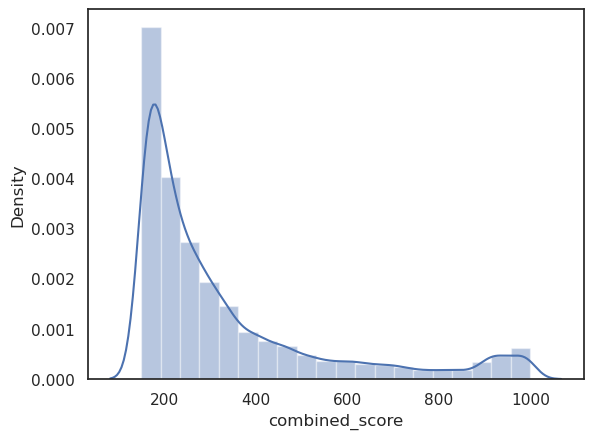

In [18]:
sns.distplot(proteins2['combined_score'], kde=True, bins=20, hist=True);

q1 [183.0, 384.0]
q3 [150.0, 685.0]


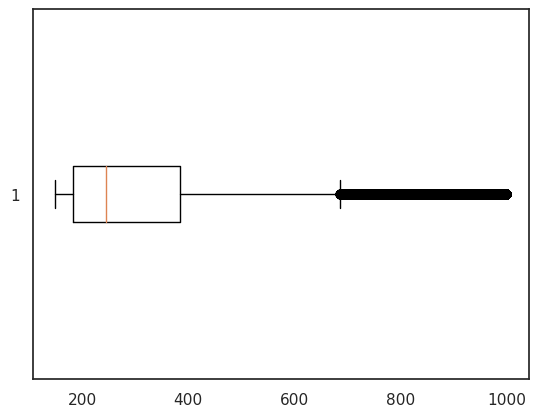

In [36]:
fig, ax = plt.subplots()
A = ax.boxplot(proteins2['combined_score'], vert=False)

# [item.get_ydata() for item in B['whiskers']]
print("q1", [item.get_xdata()[0] for item in A['whiskers']])
print("q3", [item.get_xdata()[1] for item in A['whiskers']])

In [37]:
sorted_data = np.sort(proteins2['combined_score'].values.tolist())

# Calculate the index for the 5th and 95th percentile
n = len(sorted_data)
index_5th = int(np.floor((5/100) * (n + 1)))
index_95th = int(np.ceil((95/100) * (n + 1)))

# Calculate the range in which 90% of the data lies
range_90_percent = sorted_data[index_5th - 1], sorted_data[index_95th - 1]

print("Range in which 90% of the data lies: ", range_90_percent)

Range in which 90% of the data lies:  (156, 908)


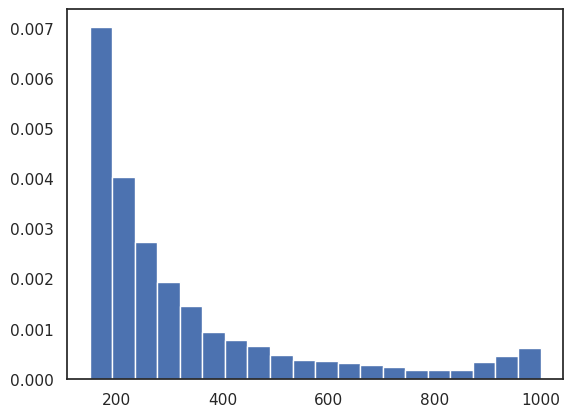

In [19]:
plt.hist(proteins2['combined_score'], 
         bins=20, 
         density=True);

### Use `combined_score` threshold

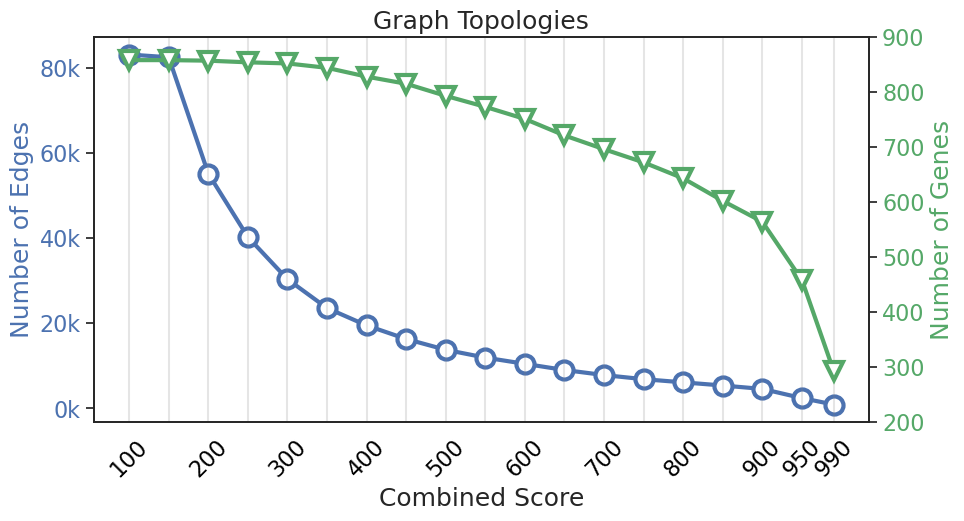

In [62]:
import matplotlib.ticker as ticker

threshs = np.append(np.arange(0.1, 1.0, 0.05), 0.99)
rows = np.repeat(None, len(threshs))
uniq_g1s, uniq_g2s = np.repeat(None, len(threshs)), np.repeat(None, len(threshs))
for i, thresh in enumerate(threshs): 
    protein_temp = proteins2[proteins2['combined_score'] > (thresh * 1_000)]
    rows[i] = protein_temp.shape[0]
    uniq_g1s[i] = len(protein_temp.gene_symbol1.unique())
    uniq_g2s[i] = len(protein_temp.gene_symbol2.unique())

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(threshs*1_000, rows, 'bo-', markersize=13, lw=3, 
         markerfacecolor='white', markeredgewidth=3);
ax1.set_xlabel("Combined Score", fontsize=18);
ax1.set_ylabel("Number of Edges", color='b', fontsize=18);
ax1.tick_params(axis='y', labelcolor = 'b', labelsize=16)

ax2 = ax1.twinx()
ax2.plot(threshs*1_000, uniq_g1s, 'gv-', markersize=13, lw=3, 
         markerfacecolor='white', markeredgewidth=3);
ax2.set_ylabel("Number of Genes", color='g', fontsize=18);
ax2.tick_params(axis='y', labelcolor = 'g', labelsize=16);
ax2.set_ylim(200, 900);

for thresh in threshs:
    ax1.axvline(x=thresh*1_000, color='grey', linestyle='-', alpha=0.2);
    
def thousands_formatter(x, pos):
    'The function that will be used to format y-axis tick labels'
    return f'{x/1000:.0f}k'

ax1.yaxis.set_major_formatter(ticker.FuncFormatter(thousands_formatter))       

plt.xticks([100, 200, 300, 400, 500, 600, 700, 800, 900, 950, 990]);
ax1.tick_params(axis='x', labelcolor='black', rotation=45, labelsize=16);
plt.title("Graph Topologies", 
          fontsize=18);
plt.show();

fig.savefig(f'outputs/graph_topologies.png', dpi=300, bbox_inches='tight')

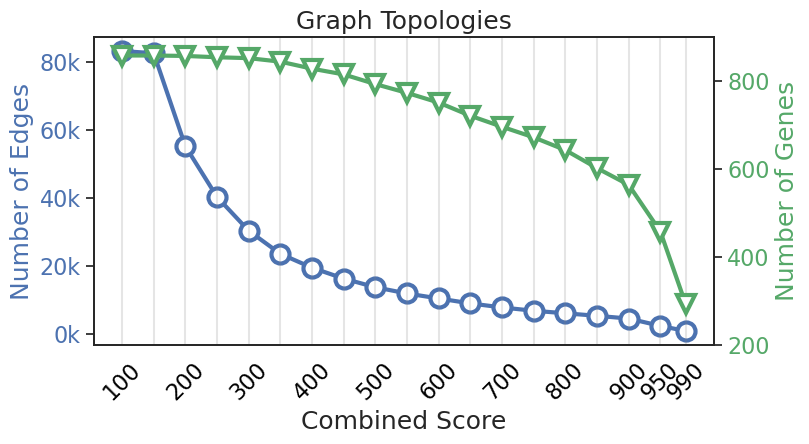

In [63]:
import matplotlib.ticker as ticker

threshs = np.append(np.arange(0.1, 1.0, 0.05), 0.99)
rows = np.repeat(None, len(threshs))
uniq_g1s, uniq_g2s = np.repeat(None, len(threshs)), np.repeat(None, len(threshs))
for i, thresh in enumerate(threshs): 
    protein_temp = proteins2[proteins2['combined_score'] > (thresh * 1_000)]
    rows[i] = protein_temp.shape[0]
    uniq_g1s[i] = len(protein_temp.gene_symbol1.unique())
    uniq_g2s[i] = len(protein_temp.gene_symbol2.unique())

fig, ax1 = plt.subplots(figsize=(8, 4))

ax1.plot(threshs*1_000, rows, 'bo-', markersize=13, lw=3, 
         markerfacecolor='white', markeredgewidth=3);
ax1.set_xlabel("Combined Score", fontsize=18);
ax1.set_ylabel("Number of Edges", color='b', fontsize=18);
ax1.tick_params(axis='y', labelcolor = 'b', labelsize=16)

ax2 = ax1.twinx()
ax2.plot(threshs*1_000, uniq_g1s, 'gv-', markersize=13, lw=3, 
         markerfacecolor='white', markeredgewidth=3);
ax2.set_ylabel("Number of Genes", color='g', fontsize=18);
ax2.tick_params(axis='y', labelcolor = 'g', labelsize=16);
ax2.set_ylim(200, 900);

for thresh in threshs:
    ax1.axvline(x=thresh*1_000, color='grey', linestyle='-', alpha=0.2);
    
def thousands_formatter(x, pos):
    'The function that will be used to format y-axis tick labels'
    return f'{x/1000:.0f}k'

ax1.yaxis.set_major_formatter(ticker.FuncFormatter(thousands_formatter))    

plt.xticks([100, 200, 300, 400, 500, 600, 700, 800, 900, 950, 990]);
ax1.tick_params(axis='x', labelcolor='black', rotation=45, labelsize=16);
plt.title("Graph Topologies", 
          fontsize=18);
plt.show();

fig.savefig(f'outputs/graph_topologies_smaller.png', dpi=300, bbox_inches='tight')

In [88]:
SCORE_THRESH = 990

# Select only the rows above the chose threshold.
proteins3 = proteins2[proteins2['combined_score'] > SCORE_THRESH]
print(f"Choosing threshold {SCORE_THRESH} we end up with shape: {proteins3.shape}")
print("Number of unique gene_symbol1's:", len(proteins3.gene_symbol1.unique()))
print("Number of unique gene_symbol2's:", len(proteins3.gene_symbol2.unique()))
assert set(proteins3.gene_symbol1.unique()) == set(proteins3.gene_symbol2.unique()), \
    "ERROR: The unique gene_symbol1's are not the same as the unique gene_symbol2's!"
UNIQ_GENE_SYMBOLS = list(set(proteins3.gene_symbol1.unique()))

Choosing threshold 990 we end up with shape: (874, 12)
Number of unique gene_symbol1's: 293
Number of unique gene_symbol2's: 293


In [38]:
# -------------------------------------- #
# Read cell-line - gene feature datasets #
# -------------------------------------- #
READ = True

if READ:
    start = time.time()
    gexpr = pd.read_pickle(PROCESSED_DATA_PATH + 'sparse_gexpr.pkl')
    cnvg = pd.read_pickle(PROCESSED_DATA_PATH + 'sparse_cnvg.pkl')
    cnvp = pd.read_pickle(PROCESSED_DATA_PATH + 'sparse_cnvp.pkl')
    mut = pd.read_pickle(PROCESSED_DATA_PATH + 'sparse_mut.pkl') 
    print(f"Took {time.time()-start:.5f} seconds to read the cell-line feature datasets.")
    print(f"""Shapes
    Gene Expression : {gexpr.shape}
    CNV Gistic      : {cnvg.shape}
    CNV Picnic      : {cnvp.shape}
    Mutation        : {mut.shape}
    """)

    gexpr.set_index('CELL_LINE_NAME', inplace=True)
    cnvg.set_index('CELL_LINE_NAME', inplace=True)
    cnvp.set_index('CELL_LINE_NAME', inplace=True)
    mut.set_index('CELL_LINE_NAME', inplace=True)    

from typing import Tuple, FrozenSet

def create_cell_line_gene_graphs(gene_symbols: List[str], 
                                 gene_features: List[pd.DataFrame], 
                                 cls: List[str],
                                 neighbor_gene_tuples: List[Tuple[int]]):
    """ 
    Creates pytorch geometric gene-gene interaction graphs for each of the
    given cell-lines. The each graph has the exact same topology, meaning
    the same gene symbols as nodes and the same edges. However, each graph
    has different gene feature values per node.

    Args: 
        gene_symbols (`List[str]`):
            List of gene symbols which need to be available as columns in the 
            gene features (`gene_features`).
        gene_features (`List[pd.DataFrame]`):
            List of feature pd.DataFrame's. All dataframe need to have all the 
            given cell-lines (`cls`) as indices and gene symbols (`gene_symbols`) as 
            columns.
        cls (`List[str]`):
            List of cell-lines for which to create graphs.
        neighbor_gene_tuples (`List[Tuple[int]]`):
            List of tuples of neighbors, where the neighbors are given as gene indices, 
            not symbols.
    Returns:
        `Dict[torch_geometric.data.Data]`:
            Dictionary with the cell-line names as keys and pytorch geometric
            gene-gene interaction graphs as values.
    """
    Gs = {}
    for cl in tqdm(cls):
        # Convert the feature values to tensors and stack them up.
        cl_features = []
        for feature in gene_features:
            cl_features.append(torch.tensor(feature.loc[cl][gene_symbols].values, dtype=torch.float64))
        features = torch.stack(cl_features).t()

        # Generate the graph.
        edge_index = torch.tensor(neighbor_gene_tuples, dtype=torch.long).t().contiguous()
        G_cl = Data(x=features, edge_index=edge_index)

        Gs[cl] = G_cl

    return Gs    

Took 0.01307 seconds to read the cell-line feature datasets.
Shapes
    Gene Expression : (862, 859)
    CNV Gistic      : (862, 859)
    CNV Picnic      : (862, 859)
    Mutation        : (862, 859)
    


In [105]:
from torch_geometric.utils import degree
from tqdm import tqdm

lst_NEIGHBOR_GENE_TUPLES_UNDIRECTED = {}
lst_GENE_SYMBOL_IDXS= {}

for thresh in [600, 700, 800, 850, 900, 950, 990]:
    print(f"{thresh:=^20}")
    SCORE_THRESH = thresh

    gexpr.reset_index(inplace=True)
    cnvg.reset_index(inplace=True)
    cnvp.reset_index(inplace=True)
    mut.reset_index(inplace=True)    

    # Select only the rows above the chose threshold.
    proteins_above = proteins2[proteins2['combined_score'] > SCORE_THRESH]
    print(f"Choosing threshold {SCORE_THRESH} we end up with shape: {proteins_above.shape}")
    print("Number of unique gene_symbol1's:", len(proteins_above.gene_symbol1.unique()))
    print("Number of unique gene_symbol2's:", len(proteins_above.gene_symbol2.unique()))
    assert set(proteins_above.gene_symbol1.unique()) == set(proteins_above.gene_symbol2.unique()), \
        "ERROR: The unique gene_symbol1's are not the same as the unique gene_symbol2's!"
    UNIQ_GENE_SYMBOLS = list(set(proteins_above.gene_symbol1.unique()))

    # Select only the gene symbols with a combined_score > SCORE_THRESH.
    temp = inter_genes[inter_genes.GENE_SYMBOL.isin(UNIQ_GENE_SYMBOLS)]# LM_GENES_IDXS[LM_GENES_IDXS.GENE_SYMBOL.isin(UNIQ_GENE_SYMBOLS)]
    temp.reset_index(inplace=True, drop=True)
    GENE_SYMBOL_IDXS = temp.copy()
    GENE_SYMBOL_IDXS.loc[:, 'GENE_INDEX'] = GENE_SYMBOL_IDXS.index
    del temp
    print("Shape before:", inter_genes.shape)
    print(inter_genes.head(3))
    print("Shape after :", GENE_SYMBOL_IDXS.shape)
    print(GENE_SYMBOL_IDXS.head(3))

#     GENE_SYMBOL_IDXS.to_csv(f'{PATH_SUMMARY_DATASETS}/{NOTEBOOKS_SUMMARY_FOLDER}/gene_symbol_idx_map_{SCORE_THRESH}.csv')

    # Remember the gene symbol index mapping.
    lst_GENE_SYMBOL_IDXS[SCORE_THRESH] = GENE_SYMBOL_IDXS

    proteins_above_with_idx = add_gene_index(proteins_above, GENE_SYMBOL_IDXS)
    proteins_above_with_idx = proteins_above_with_idx[['protein1', 'protein2', 
                                                    'gene_symbol1', 'gene_symbol2', 
                                                    'index_gene_symbol1', 'index_gene_symbol2', 
                                                    'combined_score']]

    NODES_AS_SYMBOLS = np.unique(proteins_above_with_idx[['gene_symbol1', 'gene_symbol2']].values)
    NODES_AS_INDECES = np.unique(proteins_above_with_idx[['index_gene_symbol1', 'index_gene_symbol2']].values)
    print(f"There will be {len(NODES_AS_SYMBOLS)} nodes in the graph.")
    print(f"There will be {len(NODES_AS_INDECES)} indices in the graph.")

    print(proteins_above_with_idx.shape)
    proteins_above_with_idx.head(3)

    # Create a list of tuples which hold neighbor nodes.
    gene_symbol_tuples = list(set(list(zip(proteins_above_with_idx.gene_symbol1, 
                                        proteins_above_with_idx.gene_symbol2))))
    print(gene_symbol_tuples[:5])

    # Map the list of tuples of neighbor gene nodes to the corresponding int. 
    transform_gene_tuple_to_index_tuple = lambda x : (
        GENE_SYMBOL_IDXS[GENE_SYMBOL_IDXS['GENE_SYMBOL']==x[0]]['GENE_INDEX'].values[0], 
        GENE_SYMBOL_IDXS[GENE_SYMBOL_IDXS['GENE_SYMBOL']==x[1]]['GENE_INDEX'].values[0])
    input_vec = [transform_gene_tuple_to_index_tuple(tup) for tup in gene_symbol_tuples]
    print(input_vec[:5])

    neighbor_gene_tuples = copy.deepcopy(input_vec)
    print("Number of neighbor tuples:", len(neighbor_gene_tuples))

    def is_undirected_list_of_tuples(neighbors: List[tuple[int]]):
        for neigh in neighbors:
            a, b = neigh[0], neigh[1]
            found = False
            for n in neighbors:
                if n == (b, a):
                    found = True
                    break
            assert found, f"ERROR: the list if directed since, couldn't find ({b}, {a}) for {neigh}!"
        print("SUCCESS: The given list of tuples is undirected!")

    print(is_undirected_list_of_tuples(neighbor_gene_tuples))

    NEIGHBOR_GENE_TUPLES_UNDIRECTED = neighbor_gene_tuples
    print(len(NEIGHBOR_GENE_TUPLES_UNDIRECTED))
    
    # Remember the neighbor tuples.
    lst_NEIGHBOR_GENE_TUPLES_UNDIRECTED[SCORE_THRESH] = NEIGHBOR_GENE_TUPLES_UNDIRECTED

    # Find neighbors using the indices.
    dict_as_indices = {gene_node: [] for gene_node in NODES_AS_INDECES}  # or dict(zip(nodes, []*len(nodes)))

    # Get the edges.
    for gene in dict_as_indices:
        exists_in_gene_symbol1 = not proteins_above_with_idx.loc[proteins_above_with_idx.index_gene_symbol1==gene].empty
        exists_in_gene_symbol2 = not proteins_above_with_idx.loc[proteins_above_with_idx.index_gene_symbol2==gene].empty

        neighbor_nodes = None 
        if exists_in_gene_symbol1:
            neighbor_nodes = list(set(proteins_above_with_idx.loc[proteins_above_with_idx.index_gene_symbol1==gene].index_gene_symbol2))
        elif exists_in_gene_symbol2: 
            neighbor_nodes = list(set(proteins_above_with_idx.loc[proteins_above_with_idx.index_gene_symbol2==gene].index_gene_symbol1))
        else: 
            print(f"The gene {gene} couldn't be found in the dataset!") 

        # Set neighbors for the gene.
        dict_as_indices[gene] += [neighbor_node for neighbor_node in neighbor_nodes if neighbor_node not in dict_as_indices[gene]]

    def get_uniqs(df: pd.DataFrame, col: str):
        return np.unique(df[col].values).tolist()

    # Test that all feature datasets contains exactly the same cell-lines.
    gexpr_cls = get_uniqs(gexpr, 'CELL_LINE_NAME')
    cnvg_cls = get_uniqs(cnvg, 'CELL_LINE_NAME')
    cnvp_cls = get_uniqs(cnvp, 'CELL_LINE_NAME')
    mut_cls = get_uniqs(mut, 'CELL_LINE_NAME')
    INTER_CLS = set(gexpr_cls) \
        .intersection(set(cnvp_cls)) \
        .intersection(set(cnvp_cls)) \
        .intersection(set(mut_cls))

    assert len(INTER_CLS) == len(gexpr_cls) == len(cnvg_cls) == len(cnvp_cls) == len(mut_cls), \
        "Not all feature datasets contain the exact same cell-lines as rows!"

    # Test that all feature datasets contains exactly the same gene symbols.
    inter_genes2 = set(np.unique(gexpr.columns.values).tolist()) \
        .intersection(set(np.unique(cnvg.columns.values).tolist())) \
        .intersection(set(np.unique(cnvp.columns.values).tolist())) \
        .intersection(set(np.unique(mut.columns.values).tolist()))

    assert len(inter_genes2) == \
        len(np.unique(gexpr.columns.values).tolist()) == \
        len(np.unique(cnvg.columns.values).tolist()) == \
        len(np.unique(cnvp.columns.values).tolist()) == \
        len(np.unique(mut.columns.values).tolist()), \
            "Not all feature datasets contain the exact same gene symbols as columns!"

    del gexpr_cls, cnvg_cls, cnvp_cls, mut_cls, inter_genes2
    
    gexpr.set_index('CELL_LINE_NAME', inplace=True)
    cnvg.set_index('CELL_LINE_NAME', inplace=True)
    cnvp.set_index('CELL_LINE_NAME', inplace=True)
    mut.set_index('CELL_LINE_NAME', inplace=True)

    cl_graphs = create_cell_line_gene_graphs(NODES_AS_SYMBOLS.tolist(), 
                                            [gexpr, cnvg, cnvp, mut],
                                            list(INTER_CLS),
                                            NEIGHBOR_GENE_TUPLES_UNDIRECTED)

    # Showcase topology for some cell-line examples.
    for cl in gexpr.index[:5].tolist():
        print(f"Cell-line: {cl:8s}   Graph: {cl_graphs[cl]}")
        
    degrees0 = degree(cl_graphs[cl].edge_index[0])
    degrees1 = degree(cl_graphs[cl].edge_index[1])

    mean0 = degrees0.mean().item()
    median0 = degrees0.median().item()
    std0 = degrees0.std().item()
    print(f"Node degree --> median: {median0}  --> {mean0:0.4} +- {std0:0.4}")        

#     with open(f'{PATH_SUMMARY_DATASETS}/{NOTEBOOKS_SUMMARY_FOLDER}/cl_graphs_dict_{SCORE_THRESH}.pkl', 'wb') as f:
#         pickle.dump(cl_graphs, f, protocol=pickle.HIGHEST_PROTOCOL)

========600=========
Choosing threshold 600 we end up with shape: (10436, 12)
Number of unique gene_symbol1's: 751
Number of unique gene_symbol2's: 751
Shape before: (858, 2)
  GENE_SYMBOL  GENE_INDEX
0        MYL9           0
1        NOL3           1
2       CAPN1           2
Shape after : (751, 2)
  GENE_SYMBOL  GENE_INDEX
0        MYL9           0
1       CAPN1           1
2        PGM1           2
There will be 751 nodes in the graph.
There will be 751 indices in the graph.
(10436, 7)
[('DAG1', 'PTK2'), ('PAFAH1B1', 'RHOA'), ('LIG1', 'TIMELESS'), ('GNAI2', 'FYN'), ('TP53BP2', 'PPP1R13B')]
[(75, 639), (399, 370), (507, 543), (321, 269), (525, 190)]
Number of neighbor tuples: 10436
SUCCESS: The given list of tuples is undirected!
None
10436


100%|██████████| 862/862 [00:03<00:00, 236.57it/s]


Cell-line: 22RV1      Graph: Data(x=[751, 4], edge_index=[2, 10436])
Cell-line: 23132-87   Graph: Data(x=[751, 4], edge_index=[2, 10436])
Cell-line: 42-MG-BA   Graph: Data(x=[751, 4], edge_index=[2, 10436])
Cell-line: 451Lu      Graph: Data(x=[751, 4], edge_index=[2, 10436])
Cell-line: 5637       Graph: Data(x=[751, 4], edge_index=[2, 10436])
Node degree --> median: 7.0  --> 13.9 +- 18.34
========700=========
Choosing threshold 700 we end up with shape: (7794, 12)
Number of unique gene_symbol1's: 696
Number of unique gene_symbol2's: 696
Shape before: (858, 2)
  GENE_SYMBOL  GENE_INDEX
0        MYL9           0
1        NOL3           1
2       CAPN1           2
Shape after : (696, 2)
  GENE_SYMBOL  GENE_INDEX
0        MYL9           0
1       CAPN1           1
2        PGM1           2
There will be 696 nodes in the graph.
There will be 696 indices in the graph.
(7794, 7)
[('DAG1', 'PTK2'), ('PAFAH1B1', 'RHOA'), ('LIG1', 'TIMELESS'), ('GNAI2', 'FYN'), ('TERT', 'SMARCA4')]
[(70, 587), (

100%|██████████| 862/862 [00:03<00:00, 254.40it/s]


Cell-line: 22RV1      Graph: Data(x=[696, 4], edge_index=[2, 7794])
Cell-line: 23132-87   Graph: Data(x=[696, 4], edge_index=[2, 7794])
Cell-line: 42-MG-BA   Graph: Data(x=[696, 4], edge_index=[2, 7794])
Cell-line: 451Lu      Graph: Data(x=[696, 4], edge_index=[2, 7794])
Cell-line: 5637       Graph: Data(x=[696, 4], edge_index=[2, 7794])
Node degree --> median: 5.0  --> 11.2 +- 14.73
========800=========
Choosing threshold 800 we end up with shape: (6080, 12)
Number of unique gene_symbol1's: 643
Number of unique gene_symbol2's: 643
Shape before: (858, 2)
  GENE_SYMBOL  GENE_INDEX
0        MYL9           0
1        NOL3           1
2       CAPN1           2
Shape after : (643, 2)
  GENE_SYMBOL  GENE_INDEX
0        MYL9           0
1       CAPN1           1
2        PGM1           2
There will be 643 nodes in the graph.
There will be 643 indices in the graph.
(6080, 7)
[('DAG1', 'PTK2'), ('PAFAH1B1', 'RHOA'), ('GNAI2', 'FYN'), ('TERT', 'SMARCA4'), ('GLI2', 'AKT1')]
[(65, 544), (332, 305)

100%|██████████| 862/862 [00:03<00:00, 271.85it/s]


Cell-line: 22RV1      Graph: Data(x=[643, 4], edge_index=[2, 6080])
Cell-line: 23132-87   Graph: Data(x=[643, 4], edge_index=[2, 6080])
Cell-line: 42-MG-BA   Graph: Data(x=[643, 4], edge_index=[2, 6080])
Cell-line: 451Lu      Graph: Data(x=[643, 4], edge_index=[2, 6080])
Cell-line: 5637       Graph: Data(x=[643, 4], edge_index=[2, 6080])
Node degree --> median: 5.0  --> 9.456 +- 12.51
========850=========
Choosing threshold 850 we end up with shape: (5340, 12)
Number of unique gene_symbol1's: 602
Number of unique gene_symbol2's: 602
Shape before: (858, 2)
  GENE_SYMBOL  GENE_INDEX
0        MYL9           0
1        NOL3           1
2       CAPN1           2
Shape after : (602, 2)
  GENE_SYMBOL  GENE_INDEX
0        MYL9           0
1       CAPN1           1
2        PGM1           2
There will be 602 nodes in the graph.
There will be 602 indices in the graph.
(5340, 7)
[('DAG1', 'PTK2'), ('PAFAH1B1', 'RHOA'), ('GNAI2', 'FYN'), ('TERT', 'SMARCA4'), ('GLI2', 'AKT1')]
[(62, 505), (313, 287

100%|██████████| 862/862 [00:03<00:00, 283.36it/s]


Cell-line: 22RV1      Graph: Data(x=[602, 4], edge_index=[2, 5340])
Cell-line: 23132-87   Graph: Data(x=[602, 4], edge_index=[2, 5340])
Cell-line: 42-MG-BA   Graph: Data(x=[602, 4], edge_index=[2, 5340])
Cell-line: 451Lu      Graph: Data(x=[602, 4], edge_index=[2, 5340])
Cell-line: 5637       Graph: Data(x=[602, 4], edge_index=[2, 5340])
Node degree --> median: 4.0  --> 8.87 +- 11.68
========900=========
Choosing threshold 900 we end up with shape: (4536, 12)
Number of unique gene_symbol1's: 564
Number of unique gene_symbol2's: 564
Shape before: (858, 2)
  GENE_SYMBOL  GENE_INDEX
0        MYL9           0
1        NOL3           1
2       CAPN1           2
Shape after : (564, 2)
  GENE_SYMBOL  GENE_INDEX
0        MYL9           0
1       CAPN1           1
2        PGM1           2
There will be 564 nodes in the graph.
There will be 564 indices in the graph.
(4536, 7)
[('HSPA1A', 'NR3C1'), ('DAG1', 'PTK2'), ('STAT3', 'BCL2'), ('PIK3CA', 'CAPN1'), ('EGF', 'USP6NL')]
[(52, 463), (61, 474)

100%|██████████| 862/862 [00:02<00:00, 292.92it/s]


Cell-line: 22RV1      Graph: Data(x=[564, 4], edge_index=[2, 4536])
Cell-line: 23132-87   Graph: Data(x=[564, 4], edge_index=[2, 4536])
Cell-line: 42-MG-BA   Graph: Data(x=[564, 4], edge_index=[2, 4536])
Cell-line: 451Lu      Graph: Data(x=[564, 4], edge_index=[2, 4536])
Cell-line: 5637       Graph: Data(x=[564, 4], edge_index=[2, 4536])
Node degree --> median: 4.0  --> 8.043 +- 10.61
========950=========
Choosing threshold 950 we end up with shape: (2380, 12)
Number of unique gene_symbol1's: 458
Number of unique gene_symbol2's: 458
Shape before: (858, 2)
  GENE_SYMBOL  GENE_INDEX
0        MYL9           0
1        NOL3           1
2       CAPN1           2
Shape after : (458, 2)
  GENE_SYMBOL  GENE_INDEX
0        MYL9           0
1       CAPN1           1
2        PGM1           2
There will be 458 nodes in the graph.
There will be 458 indices in the graph.
(2380, 7)
[('DAG1', 'PTK2'), ('NOTCH1', 'JUN'), ('TP53', 'HDAC2'), ('ABL1', 'PTPN1'), ('ABL1', 'SHC1')]
[(50, 389), (13, 289), (3

100%|██████████| 862/862 [00:02<00:00, 332.31it/s]


Cell-line: 22RV1      Graph: Data(x=[458, 4], edge_index=[2, 2380])
Cell-line: 23132-87   Graph: Data(x=[458, 4], edge_index=[2, 2380])
Cell-line: 42-MG-BA   Graph: Data(x=[458, 4], edge_index=[2, 2380])
Cell-line: 451Lu      Graph: Data(x=[458, 4], edge_index=[2, 2380])
Cell-line: 5637       Graph: Data(x=[458, 4], edge_index=[2, 2380])
Node degree --> median: 2.0  --> 5.197 +- 7.032
========990=========
Choosing threshold 990 we end up with shape: (874, 12)
Number of unique gene_symbol1's: 293
Number of unique gene_symbol2's: 293
Shape before: (858, 2)
  GENE_SYMBOL  GENE_INDEX
0        MYL9           0
1        NOL3           1
2       CAPN1           2
Shape after : (293, 2)
  GENE_SYMBOL  GENE_INDEX
0       CAPN1           0
1       GRB10           1
2        CDK4           2
There will be 293 nodes in the graph.
There will be 293 indices in the graph.
(874, 7)
[('NFKB2', 'RELB'), ('TP53', 'HDAC2'), ('RB1', 'CCNA2'), ('CCNE2', 'CDK1'), ('HSPA8', 'DNAJB1')]
[(11, 268), (225, 24), (

100%|██████████| 862/862 [00:02<00:00, 403.94it/s]

Cell-line: 22RV1      Graph: Data(x=[293, 4], edge_index=[2, 874])
Cell-line: 23132-87   Graph: Data(x=[293, 4], edge_index=[2, 874])
Cell-line: 42-MG-BA   Graph: Data(x=[293, 4], edge_index=[2, 874])
Cell-line: 451Lu      Graph: Data(x=[293, 4], edge_index=[2, 874])
Cell-line: 5637       Graph: Data(x=[293, 4], edge_index=[2, 874])
Node degree --> median: 2.0  --> 2.983 +- 3.269


In [41]:
from torch_geometric.utils import degree
from tqdm import tqdm

lst_NEIGHBOR_GENE_TUPLES_UNDIRECTED = {}
lst_GENE_SYMBOL_IDXS= {}

for thresh in list(np.append(np.arange(0.1, 1.0, 0.05), 0.99) * 1000):
    print(f"{thresh:=^20}")
    SCORE_THRESH = thresh

    gexpr.reset_index(inplace=True)
    cnvg.reset_index(inplace=True)
    cnvp.reset_index(inplace=True)
    mut.reset_index(inplace=True)    

    # Select only the rows above the chose threshold.
    proteins_above = proteins2[proteins2['combined_score'] > SCORE_THRESH]
    assert set(proteins_above.gene_symbol1.unique()) == set(proteins_above.gene_symbol2.unique()), \
        "ERROR: The unique gene_symbol1's are not the same as the unique gene_symbol2's!"
    UNIQ_GENE_SYMBOLS = list(set(proteins_above.gene_symbol1.unique()))

    # Select only the gene symbols with a combined_score > SCORE_THRESH.
    temp = inter_genes[inter_genes.GENE_SYMBOL.isin(UNIQ_GENE_SYMBOLS)]# LM_GENES_IDXS[LM_GENES_IDXS.GENE_SYMBOL.isin(UNIQ_GENE_SYMBOLS)]
    temp.reset_index(inplace=True, drop=True)
    GENE_SYMBOL_IDXS = temp.copy()
    GENE_SYMBOL_IDXS.loc[:, 'GENE_INDEX'] = GENE_SYMBOL_IDXS.index
    del temp

#     GENE_SYMBOL_IDXS.to_csv(f'{PATH_SUMMARY_DATASETS}/{NOTEBOOKS_SUMMARY_FOLDER}/gene_symbol_idx_map_{SCORE_THRESH}.csv')

    # Remember the gene symbol index mapping.
    lst_GENE_SYMBOL_IDXS[SCORE_THRESH] = GENE_SYMBOL_IDXS

    proteins_above_with_idx = add_gene_index(proteins_above, GENE_SYMBOL_IDXS)
    proteins_above_with_idx = proteins_above_with_idx[['protein1', 'protein2', 
                                                    'gene_symbol1', 'gene_symbol2', 
                                                    'index_gene_symbol1', 'index_gene_symbol2', 
                                                    'combined_score']]

    NODES_AS_SYMBOLS = np.unique(proteins_above_with_idx[['gene_symbol1', 'gene_symbol2']].values)
    NODES_AS_INDECES = np.unique(proteins_above_with_idx[['index_gene_symbol1', 'index_gene_symbol2']].values)

    proteins_above_with_idx.head(3)

    # Create a list of tuples which hold neighbor nodes.
    gene_symbol_tuples = list(set(list(zip(proteins_above_with_idx.gene_symbol1, 
                                        proteins_above_with_idx.gene_symbol2))))

    # Map the list of tuples of neighbor gene nodes to the corresponding int. 
    transform_gene_tuple_to_index_tuple = lambda x : (
        GENE_SYMBOL_IDXS[GENE_SYMBOL_IDXS['GENE_SYMBOL']==x[0]]['GENE_INDEX'].values[0], 
        GENE_SYMBOL_IDXS[GENE_SYMBOL_IDXS['GENE_SYMBOL']==x[1]]['GENE_INDEX'].values[0])
    input_vec = [transform_gene_tuple_to_index_tuple(tup) for tup in gene_symbol_tuples]

    neighbor_gene_tuples = copy.deepcopy(input_vec)

    def is_undirected_list_of_tuples(neighbors: List[tuple[int]]):
        for neigh in neighbors:
            a, b = neigh[0], neigh[1]
            found = False
            for n in neighbors:
                if n == (b, a):
                    found = True
                    break
            assert found, f"ERROR: the list if directed since, couldn't find ({b}, {a}) for {neigh}!"
        print("SUCCESS: The given list of tuples is undirected!")
        
    NEIGHBOR_GENE_TUPLES_UNDIRECTED = neighbor_gene_tuples
    
    # Remember the neighbor tuples.
    lst_NEIGHBOR_GENE_TUPLES_UNDIRECTED[SCORE_THRESH] = NEIGHBOR_GENE_TUPLES_UNDIRECTED

    # Find neighbors using the indices.
    dict_as_indices = {gene_node: [] for gene_node in NODES_AS_INDECES}  # or dict(zip(nodes, []*len(nodes)))

    # Get the edges.
    for gene in dict_as_indices:
        exists_in_gene_symbol1 = not proteins_above_with_idx.loc[proteins_above_with_idx.index_gene_symbol1==gene].empty
        exists_in_gene_symbol2 = not proteins_above_with_idx.loc[proteins_above_with_idx.index_gene_symbol2==gene].empty

        neighbor_nodes = None 
        if exists_in_gene_symbol1:
            neighbor_nodes = list(set(proteins_above_with_idx.loc[proteins_above_with_idx.index_gene_symbol1==gene].index_gene_symbol2))
        elif exists_in_gene_symbol2: 
            neighbor_nodes = list(set(proteins_above_with_idx.loc[proteins_above_with_idx.index_gene_symbol2==gene].index_gene_symbol1))
        else: 
            print(f"The gene {gene} couldn't be found in the dataset!") 

        # Set neighbors for the gene.
        dict_as_indices[gene] += [neighbor_node for neighbor_node in neighbor_nodes if neighbor_node not in dict_as_indices[gene]]

    def get_uniqs(df: pd.DataFrame, col: str):
        return np.unique(df[col].values).tolist()

    # Test that all feature datasets contains exactly the same cell-lines.
    gexpr_cls = get_uniqs(gexpr, 'CELL_LINE_NAME')
    cnvg_cls = get_uniqs(cnvg, 'CELL_LINE_NAME')
    cnvp_cls = get_uniqs(cnvp, 'CELL_LINE_NAME')
    mut_cls = get_uniqs(mut, 'CELL_LINE_NAME')
    INTER_CLS = set(gexpr_cls) \
        .intersection(set(cnvp_cls)) \
        .intersection(set(cnvp_cls)) \
        .intersection(set(mut_cls))

    assert len(INTER_CLS) == len(gexpr_cls) == len(cnvg_cls) == len(cnvp_cls) == len(mut_cls), \
        "Not all feature datasets contain the exact same cell-lines as rows!"

    # Test that all feature datasets contains exactly the same gene symbols.
    inter_genes2 = set(np.unique(gexpr.columns.values).tolist()) \
        .intersection(set(np.unique(cnvg.columns.values).tolist())) \
        .intersection(set(np.unique(cnvp.columns.values).tolist())) \
        .intersection(set(np.unique(mut.columns.values).tolist()))

    assert len(inter_genes2) == \
        len(np.unique(gexpr.columns.values).tolist()) == \
        len(np.unique(cnvg.columns.values).tolist()) == \
        len(np.unique(cnvp.columns.values).tolist()) == \
        len(np.unique(mut.columns.values).tolist()), \
            "Not all feature datasets contain the exact same gene symbols as columns!"

    del gexpr_cls, cnvg_cls, cnvp_cls, mut_cls, inter_genes2
    
    gexpr.set_index('CELL_LINE_NAME', inplace=True)
    cnvg.set_index('CELL_LINE_NAME', inplace=True)
    cnvp.set_index('CELL_LINE_NAME', inplace=True)
    mut.set_index('CELL_LINE_NAME', inplace=True)

    cl_graphs = create_cell_line_gene_graphs(NODES_AS_SYMBOLS.tolist(), 
                                            [gexpr, cnvg, cnvp, mut],
                                            list(INTER_CLS),
                                            NEIGHBOR_GENE_TUPLES_UNDIRECTED)

    # Showcase topology for some cell-line examples.
    for cl in gexpr.index[:1].tolist():
        print(f"Cell-line: {cl:8s}   Graph: {cl_graphs[cl]}")
        
    degrees0 = degree(cl_graphs[cl].edge_index[0])
    degrees1 = degree(cl_graphs[cl].edge_index[1])

    mean0 = degrees0.mean().item()
    median0 = degrees0.median().item()
    std0 = degrees0.std().item()
    print(f"Node degree --> median: {median0}  --> {mean0:0.4} +- {std0:0.4}")        

#     with open(f'{PATH_SUMMARY_DATASETS}/{NOTEBOOKS_SUMMARY_FOLDER}/cl_graphs_dict_{SCORE_THRESH}.pkl', 'wb') as f:
#         pickle.dump(cl_graphs, f, protocol=pickle.HIGHEST_PROTOCOL)

=======100.0========


100%|██████████| 862/862 [00:10<00:00, 84.07it/s]


Cell-line: 22RV1      Graph: Data(x=[858, 4], edge_index=[2, 83126])
Node degree --> median: 73.0  --> 96.88 +- 77.99
=150.00000000000003=


100%|██████████| 862/862 [00:10<00:00, 81.93it/s]


Cell-line: 22RV1      Graph: Data(x=[858, 4], edge_index=[2, 82480])
Node degree --> median: 72.0  --> 96.13 +- 77.67
=200.00000000000003=


100%|██████████| 862/862 [00:08<00:00, 107.62it/s]


Cell-line: 22RV1      Graph: Data(x=[857, 4], edge_index=[2, 55152])
Node degree --> median: 44.0  --> 64.35 +- 61.09
=250.00000000000006=


100%|██████████| 862/862 [00:07<00:00, 121.47it/s]


Cell-line: 22RV1      Graph: Data(x=[854, 4], edge_index=[2, 40244])
Node degree --> median: 29.0  --> 47.12 +- 50.2
=300.00000000000006=


100%|██████████| 862/862 [00:05<00:00, 145.44it/s]


Cell-line: 22RV1      Graph: Data(x=[852, 4], edge_index=[2, 30326])
Node degree --> median: 21.0  --> 35.59 +- 41.63
=350.0000000000001==


100%|██████████| 862/862 [00:05<00:00, 160.82it/s]


Cell-line: 22RV1      Graph: Data(x=[844, 4], edge_index=[2, 23544])
Node degree --> median: 15.0  --> 27.9 +- 34.94
=400.0000000000001==


100%|██████████| 862/862 [00:05<00:00, 164.06it/s]


Cell-line: 22RV1      Graph: Data(x=[828, 4], edge_index=[2, 19464])
Node degree --> median: 12.0  --> 23.51 +- 30.55
=450.00000000000006=


100%|██████████| 862/862 [00:04<00:00, 184.00it/s]


Cell-line: 22RV1      Graph: Data(x=[815, 4], edge_index=[2, 16274])
Node degree --> median: 10.0  --> 19.97 +- 26.6
=500.0000000000001==


100%|██████████| 862/862 [00:04<00:00, 199.13it/s]


Cell-line: 22RV1      Graph: Data(x=[793, 4], edge_index=[2, 13732])
Node degree --> median: 9.0  --> 17.32 +- 23.07
=550.0000000000001==


100%|██████████| 862/862 [00:04<00:00, 209.89it/s]


Cell-line: 22RV1      Graph: Data(x=[773, 4], edge_index=[2, 11898])
Node degree --> median: 8.0  --> 15.39 +- 20.47
=600.0000000000002==


100%|██████████| 862/862 [00:03<00:00, 220.08it/s]


Cell-line: 22RV1      Graph: Data(x=[751, 4], edge_index=[2, 10436])
Node degree --> median: 7.0  --> 13.9 +- 18.34
=650.0000000000001==


100%|██████████| 862/862 [00:03<00:00, 232.35it/s]


Cell-line: 22RV1      Graph: Data(x=[721, 4], edge_index=[2, 8986])
Node degree --> median: 6.0  --> 12.46 +- 16.44
=700.0000000000002==


100%|██████████| 862/862 [00:03<00:00, 246.56it/s]


Cell-line: 22RV1      Graph: Data(x=[696, 4], edge_index=[2, 7794])
Node degree --> median: 5.0  --> 11.2 +- 14.73
=750.0000000000002==


100%|██████████| 862/862 [00:03<00:00, 252.07it/s]


Cell-line: 22RV1      Graph: Data(x=[672, 4], edge_index=[2, 6828])
Node degree --> median: 5.0  --> 10.16 +- 13.61
=800.0000000000001==


100%|██████████| 862/862 [00:03<00:00, 263.98it/s]


Cell-line: 22RV1      Graph: Data(x=[643, 4], edge_index=[2, 6080])
Node degree --> median: 5.0  --> 9.456 +- 12.51
=850.0000000000002==


100%|██████████| 862/862 [00:03<00:00, 274.87it/s]


Cell-line: 22RV1      Graph: Data(x=[602, 4], edge_index=[2, 5340])
Node degree --> median: 4.0  --> 8.87 +- 11.68
=900.0000000000002==


100%|██████████| 862/862 [00:03<00:00, 287.17it/s]


Cell-line: 22RV1      Graph: Data(x=[564, 4], edge_index=[2, 4536])
Node degree --> median: 4.0  --> 8.043 +- 10.61
=950.0000000000003==


100%|██████████| 862/862 [00:02<00:00, 329.22it/s]


Cell-line: 22RV1      Graph: Data(x=[458, 4], edge_index=[2, 2380])
Node degree --> median: 2.0  --> 5.197 +- 7.032
=======990.0========


100%|██████████| 862/862 [00:02<00:00, 403.28it/s]

Cell-line: 22RV1      Graph: Data(x=[293, 4], edge_index=[2, 874])
Node degree --> median: 2.0  --> 2.983 +- 3.269


In [99]:
test = cl_graphs.get('PCI-38')
test

Data(x=[293, 4], edge_index=[2, 874])

In [104]:
degrees0 = degree(test.edge_index[0])
degrees1 = degree(test.edge_index[1])

mean0 = degrees0.mean().item()
median0 = degrees0.median().item()
std0 = degrees0.std().item()
print(f"Node degree --> median: {median0}  --> {mean0:0.4} +- {std0:0.4}")

mean1 = degrees1.mean().item()
median1 = degrees1.median().item()
std1 = degrees1.std().item()
print(f"Node degree --> median: {median1}  --> {mean1:0.4} +- {std1:0.4}")


Node degree --> median: 2.0  --> 2.983 +- 3.269
Node degree --> median: 2.0  --> 2.983 +- 3.269


### Correct indices

In [65]:
def get_proteins_and_genes_above_thresh(proteins: pd.DataFrame,
                                        genes: pd.DataFrame,
                                        thresh: float):
    """Return new proteins dataframe and gene dataframe by only selecting 
    data above the chosen threshold."""
    p_sub = proteins[proteins['combined_score'] > thresh]
    gene_symbols = list(set(p_sub.gene_symbol1.unique()))

    # Select only the gene symbols with a combined_score > SCORE_THRESH.
    gene_sub = genes[genes.GENE_SYMBOL.isin(gene_symbols)].reset_index(drop=True)
    gene_sub.loc[:, 'GENE_INDEX'] = gene_sub.index

    return p_sub, gene_sub

p_sub, gene_sub = get_proteins_and_genes_above_thresh(proteins2, inter_genes, SCORE_THRESH)
print(p_sub.shape)
print(gene_sub.shape)

(874, 12)
(293, 2)


In [66]:
# Select only the gene symbols with a combined_score > SCORE_THRESH.
temp = inter_genes[inter_genes.GENE_SYMBOL.isin(UNIQ_GENE_SYMBOLS)]
temp.reset_index(inplace=True, drop=True)
inter_genes_thresh_700 = temp.copy()
inter_genes_thresh_700.loc[:, 'GENE_INDEX'] = inter_genes_thresh_700.index
del temp
print("Shape before:", inter_genes.shape)
print(inter_genes.head(3))
print("Shape after :", inter_genes_thresh_700.shape)
print(inter_genes_thresh_700.head(3))

inter_genes_thresh_700.to_csv(PROCESSED_DATA_PATH + 'thresh_700_inter_genes.csv', header=True, index=False)

Shape before: (858, 2)
  GENE_SYMBOL  GENE_INDEX
0        MYL9           0
1        NOL3           1
2       CAPN1           2
Shape after : (293, 2)
  GENE_SYMBOL  GENE_INDEX
0       CAPN1           0
1       GRB10           1
2        CDK4           2


### Add gene index to proteins dataset

In [67]:
proteins4 = add_gene_index(proteins3, inter_genes_thresh_700)
proteins4 = proteins4[['protein1', 'protein2', 'gene_symbol1', 'gene_symbol2', 
                       'index_gene_symbol1', 'index_gene_symbol2', 'combined_score']]

NODES_AS_SYMBOLS = list(np.unique(proteins4[['gene_symbol1', 'gene_symbol2']].values))
NODES_AS_INDECES = list(np.unique(proteins4[['index_gene_symbol1', 'index_gene_symbol2']].values))
print(f"There will be {len(NODES_AS_SYMBOLS)} nodes in the graph.")
print(f"There will be {len(NODES_AS_INDECES)} indices in the graph.")

print(proteins4.shape)
proteins4.head(3)

There will be 293 nodes in the graph.
There will be 293 indices in the graph.
(874, 7)


,protein1,protein2,gene_symbol1,gene_symbol2,index_gene_symbol1,index_gene_symbol2,combined_score
0,ENSP00000001008,ENSP00000231509,FKBP4,NR3C1,22,240,999
1,ENSP00000005257,ENSP00000361120,RALA,RALGDS,118,162,998
2,ENSP00000006275,ENSP00000480332,TRAPPC6A,TRAPPC3,21,173,999


In [68]:
neighbor_gene_tuples = get_neighbor_tuples(proteins4, inter_genes_thresh_700)
print(neighbor_gene_tuples[:5])
print("Number of neighbor tuples:", len(neighbor_gene_tuples))

[('NFKB2', 'RELB'), ('TP53', 'HDAC2'), ('RB1', 'CCNA2'), ('CCNE2', 'CDK1'), ('HSPA8', 'DNAJB1')]
[(11, 268), (225, 24), (241, 274), (57, 259), (200, 151)]
Number of neighbor tuples: 874


In [69]:
neighbor_gene_tuples_undirected = neighbor_gene_tuples if is_undirected_list_of_tuples(neighbor_gene_tuples) else None

SUCCESS: The given list of tuples is undirected!


### Dictionary of neihbors per gene

In [70]:
dict_as_indices = create_graph_dict_with_indices(proteins4, NODES_AS_INDECES)

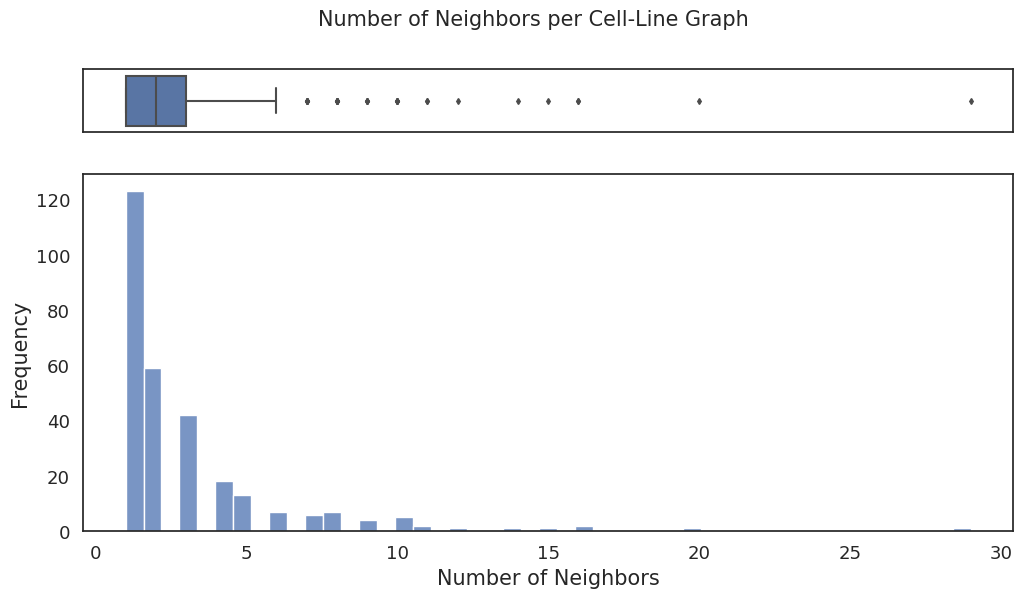

nr_neighbors mean  : 3
nr_neighbors median: 2
Thus, on average there are   3 neighbors per node.
Note that there are 293 keys/nodes/genes in total.
Thus, on average 1.02 % of all genes are neighbors.


,nr_neighbors
count,293.000000
mean,2.982935
std,3.269260
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,29.000000


In [71]:
# How many neighbors are there on average?
len_of_neighbors = [len(neighbors) for _, neighbors in dict_as_indices.items()]
assert len(len_of_neighbors) == len(NODES_AS_INDECES)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(12, 6));

sns.histplot(x=len_of_neighbors, kde=False, ax=ax_hist); #, element="step"
sns.boxplot(x=len_of_neighbors, ax=ax_box, fliersize=3);
plt.suptitle("Number of Neighbors per Cell-Line Graph", fontsize=PlottingParameters.TITLE_FONTSIZE.value);
plt.xlabel("Number of Neighbors", fontsize=PlottingParameters.XLABEL_FONTSIZE.value);
plt.ylabel("Frequency", fontsize=PlottingParameters.YLABEL_FONTSIZE.value);
ax_hist.tick_params(axis='both', which='major', labelsize=PlottingParameters.XTICKS_LABELSIZE.value);

ax_box.set(xlabel='');
plt.show();
# f.savefig(f'{IMGS_PATH}/NumberOfNeighborsPerCellLineGraph.eps', format='eps');
# f.savefig(f'{PATH_SUMMARY_DATASETS}/{NOTEBOOKS_SUMMARY_FOLDER}/NumberOfNeighborsPerCellLineGraph.eps', format='eps');

print("nr_neighbors mean  :", round(np.mean(len_of_neighbors)))
print("nr_neighbors median:", round(np.median(len_of_neighbors)))
print(f"Thus, on average there are {np.mean(len_of_neighbors):3.0f} neighbors per node.")
print(f"Note that there are {len(dict_as_indices.keys())} keys/nodes/genes in total.")
print(f"Thus, on average {100*np.mean(len_of_neighbors)/len(dict_as_indices.keys()):2.2f} %" +
    " of all genes are neighbors.")

pd.DataFrame(len_of_neighbors, columns=['nr_neighbors']).describe()

### Load node features

In [62]:
mut = pd.read_pickle(PROCESSED_DATA_PATH + 'sparse_mut.pkl')
print(mut.shape)

(862, 859)


In [297]:
gexpr = pd.read_pickle(PROCESSED_DATA_PATH + 'sparse_gexpr.pkl')
cnvg = pd.read_pickle(PROCESSED_DATA_PATH + 'sparse_cnvg.pkl')
cnvp = pd.read_pickle(PROCESSED_DATA_PATH + 'sparse_cnvp.pkl')
mut = pd.read_pickle(PROCESSED_DATA_PATH + 'sparse_mut.pkl')

In [298]:
def get_uniqs(df: pd.DataFrame, col: str):
    return np.unique(df[col].values).tolist()

def get_intersecting_cell_lines(gexpr, cnvg, cnvp, mut):
    # Test that all feature datasets contains exactly the same cell-lines.
    gexpr_cls = get_uniqs(gexpr, 'CELL_LINE_NAME')
    cnvg_cls = get_uniqs(cnvg, 'CELL_LINE_NAME')
    cnvp_cls = get_uniqs(cnvp, 'CELL_LINE_NAME')
    mut_cls = get_uniqs(mut, 'CELL_LINE_NAME')
    inter_cls = set(gexpr_cls) \
        .intersection(set(cnvp_cls)) \
        .intersection(set(cnvp_cls)) \
        .intersection(set(mut_cls))

    assert len(inter_cls) == len(gexpr_cls) == len(cnvg_cls) == len(cnvp_cls) == len(mut_cls), \
        "Not all feature datasets contain the exact same cell-lines as rows!"
    del gexpr_cls, cnvg_cls, cnvp_cls, mut_cls

    return inter_cls

def get_intersecting_genes(gexpr, cnvg, cnvp, mut):
    # Test that all feature datasets contains exactly the same gene symbols.
    inter_genes = set(np.unique(gexpr.columns.values).tolist()) \
        .intersection(set(np.unique(cnvg.columns.values).tolist())) \
        .intersection(set(np.unique(cnvp.columns.values).tolist())) \
        .intersection(set(np.unique(mut.columns.values).tolist()))

    assert len(inter_genes) == \
        len(np.unique(gexpr.columns.values).tolist()) == \
        len(np.unique(cnvg.columns.values).tolist()) == \
        len(np.unique(cnvp.columns.values).tolist()) == \
        len(np.unique(mut.columns.values).tolist()), \
            "Not all feature datasets contain the exact same gene symbols as columns!"

    return inter_genes

In [299]:
inter_cls = get_intersecting_cell_lines(gexpr, cnvg, cnvp, mut)
inter_genes = get_intersecting_genes(gexpr, cnvg, cnvp, mut)
print(len(inter_cls))
print(len(inter_genes))

870
859


In [242]:
gexpr.set_index('CELL_LINE_NAME', inplace=True)
cnvg.set_index('CELL_LINE_NAME', inplace=True)
cnvp.set_index('CELL_LINE_NAME', inplace=True)
mut.set_index('CELL_LINE_NAME', inplace=True)

### Build gene-gene interaction graph

In [246]:
from typing import Tuple, Set, FrozenSet
from tqdm import tqdm

def create_cell_line_gene_graphs(gene_symbols: List[str], 
                                 gene_features: List[pd.DataFrame], 
                                 cls: Set[str],
                                 neighbor_gene_tuples: List[Tuple[int]]):
    """ 
    Creates pytorch geometric gene-gene interaction graphs for each of the
    given cell-lines. The each graph has the exact same topology, meaning
    the same gene symbols as nodes and the same edges. However, each graph
    has different gene feature values per node.

    Args: 
        gene_symbols (`List[str]`):
            List of gene symbols which need to be available as columns in the 
            gene features (`gene_features`).
        gene_features (`List[pd.DataFrame]`):
            List of feature pd.DataFrame's. All dataframe need to have all the 
            given cell-lines (`cls`) as indices and gene symbols (`gene_symbols`) as 
            columns.
        cls (`Set[str]`):
            List of cell-lines for which to create graphs.
        neighbor_gene_tuples (`List[Tuple[int]]`):
            List of tuples of neighbors, where the neighbors are given as gene indices, 
            not symbols.
    Returns:
        `Dict[torch_geometric.data.Data]`:
            Dictionary with the cell-line names as keys and pytorch geometric
            gene-gene interaction graphs as values.
    """
    Gs = {}
    for cl in tqdm(cls):
        # Convert the feature values to tensors and stack them up.
        cl_features = []
        for feature in gene_features:
            cl_features.append(torch.tensor(feature.loc[cl][gene_symbols].values, dtype=torch.float64))
        features = torch.stack(cl_features).t()

        # Generate the graph.
        edge_index = torch.tensor(neighbor_gene_tuples, dtype=torch.long).t().contiguous()
        G_cl = Data(x=features, edge_index=edge_index)

        Gs[cl] = G_cl

    return Gs

cl_graphs = create_cell_line_gene_graphs(NODES_AS_SYMBOLS, 
                                         [gexpr, cnvg, cnvp, mut],
                                         inter_cls,
                                         neighbor_gene_tuples_undirected)

# Showcase topology for some cell-line examples.
for cl in gexpr.index[:5].tolist():
    print(f"Cell-line: {cl:8s}   Graph: {cl_graphs[cl]}")

100%|██████████| 870/870 [00:06<00:00, 132.94it/s]

Cell-line: 22RV1      Graph: Data(x=[696, 4], edge_index=[2, 7794])
Cell-line: 23132-87   Graph: Data(x=[696, 4], edge_index=[2, 7794])
Cell-line: 42-MG-BA   Graph: Data(x=[696, 4], edge_index=[2, 7794])
Cell-line: 451Lu      Graph: Data(x=[696, 4], edge_index=[2, 7794])
Cell-line: 5637       Graph: Data(x=[696, 4], edge_index=[2, 7794])


In [247]:
import pickle 
with open(PROCESSED_DATA_PATH + 'thresh_700_gene_graphs.pkl', 'wb') as f:
    pickle.dump(cl_graphs, f, protocol=pickle.HIGHEST_PROTOCOL)

In [255]:
print(len(drm[drm.DATASET=='GDSC1'].CELL_LINE_NAME.unique()))
print(len(drm[drm.DATASET=='GDSC2'].CELL_LINE_NAME.unique()))

987
809


## Feature subset with only the genes over the chosen threshold

In [265]:
gexpr = pd.read_pickle(PROCESSED_DATA_PATH + 'sparse_gexpr.pkl')
cnvg = pd.read_pickle(PROCESSED_DATA_PATH + 'sparse_cnvg.pkl')
cnvp = pd.read_pickle(PROCESSED_DATA_PATH + 'sparse_cnvp.pkl')
mut = pd.read_pickle(PROCESSED_DATA_PATH + 'sparse_mut.pkl')
print(gexpr.shape)

inter_genes_above_thresh = pd.read_csv(PROCESSED_DATA_PATH + 'thresh_700_inter_genes.csv')
print(inter_genes_above_thresh.shape)
inter_genes_above_thresh.head(3)

(870, 859)
(696, 2)


,GENE_SYMBOL,GENE_INDEX
0,LPAR2,0
1,PEX11A,1
2,MAPKAPK2,2


In [269]:
gexpr2 = gexpr.loc[:, gexpr.columns.isin(['CELL_LINE_NAME'] + inter_genes_above_thresh.GENE_SYMBOL.values.tolist())]
cnvg2 = cnvg.loc[:, cnvg.columns.isin(['CELL_LINE_NAME'] + inter_genes_above_thresh.GENE_SYMBOL.values.tolist())]
cnvp2 = cnvp.loc[:, cnvp.columns.isin(['CELL_LINE_NAME'] + inter_genes_above_thresh.GENE_SYMBOL.values.tolist())]
mut2 = mut.loc[:, mut.columns.isin(['CELL_LINE_NAME'] + inter_genes_above_thresh.GENE_SYMBOL.values.tolist())]
assert gexpr2.shape == cnvg2.shape == cnvp2.shape == mut2.shape, \
    "ERROR: The shapes of all feature dataframes are not equal."
print(gexpr2.shape)

(870, 697)


In [274]:
# These dataframe have been sparsed by intersecting genes after chosing 
# only the genes with combined_score > 700.
gexpr2.to_pickle(PROCESSED_DATA_PATH + 'thresh_700_gexpr.pkl')
cnvg2.to_pickle(PROCESSED_DATA_PATH + 'thresh_700_cnvg.pkl')
cnvp2.to_pickle(PROCESSED_DATA_PATH + 'thresh_700_cnvp.pkl')
mut2.to_pickle(PROCESSED_DATA_PATH + 'thresh_700_mut.pkl')

### Split by GDSC dataset

In [469]:
gexpr2 = pd.read_pickle(PROCESSED_DATA_PATH + 'thresh_700_gexpr.pkl')
cnvg2 = pd.read_pickle(PROCESSED_DATA_PATH + 'thresh_700_cnvg.pkl')
cnvp2 = pd.read_pickle(PROCESSED_DATA_PATH + 'thresh_700_cnvp.pkl')
mut2 = pd.read_pickle(PROCESSED_DATA_PATH + 'thresh_700_mut.pkl')

In [278]:
inter_cls_gdsc = set(drm.CELL_LINE_NAME.unique())\
    .intersection(set(gexpr2.CELL_LINE_NAME.unique()))\
    .intersection(set(cnvg2.CELL_LINE_NAME.unique()))\
    .intersection(set(cnvp2.CELL_LINE_NAME.unique()))\
    .intersection(set(mut2.CELL_LINE_NAME.unique()))

inter_cls_gdsc1 = set(drm[drm.DATASET=='GDSC1'].CELL_LINE_NAME.unique())\
    .intersection(set(gexpr2.CELL_LINE_NAME.unique()))\
    .intersection(set(cnvg2.CELL_LINE_NAME.unique()))\
    .intersection(set(cnvp2.CELL_LINE_NAME.unique()))\
    .intersection(set(mut2.CELL_LINE_NAME.unique()))

inter_cls_gdsc2 = set(drm[drm.DATASET=='GDSC2'].CELL_LINE_NAME.unique())\
    .intersection(set(gexpr2.CELL_LINE_NAME.unique()))\
    .intersection(set(cnvg2.CELL_LINE_NAME.unique()))\
    .intersection(set(cnvp2.CELL_LINE_NAME.unique()))\
    .intersection(set(mut2.CELL_LINE_NAME.unique()))

print(f"When choosing both GDSC databases the number of intersecting cell-lines is {len(list(inter_cls_gdsc))}\n" + \
      f"When choosing only GDSC1 database the number of intersecting cell-lines is {len(list(inter_cls_gdsc1))}\n" + \
      f"When choosing both GDSC2 databases the number of intersecting cell-lines is {len(list(inter_cls_gdsc2))}")

When choosing both GDSC databases the number of intersecting cell-lines is 870
When choosing only GDSC1 database the number of intersecting cell-lines is 869
When choosing both GDSC2 databases the number of intersecting cell-lines is 729


In [337]:
pd.DataFrame({'CELL_LINE_NAME': list(inter_cls_gdsc2)})\
    .to_csv(PROCESSED_DATA_PATH + 'thresh_700_gdsc2_inter_cls.csv', header=True, index=False)    

In [330]:
# Choose only GDSC1.
drmGDSC1 = drm[drm.DATASET=='GDSC1']
drmGDSC1 = drmGDSC1[drmGDSC1.CELL_LINE_NAME.isin(inter_cls_gdsc1)]
gexprGDSC1 = gexpr2[gexpr2.CELL_LINE_NAME.isin(inter_cls_gdsc1)]
cnvgGDSC1 = cnvg2[cnvg2.CELL_LINE_NAME.isin(inter_cls_gdsc1)]
cnvpGDSC1 = cnvp2[cnvp2.CELL_LINE_NAME.isin(inter_cls_gdsc1)]
mutGDSC1 = mut2[mut2.CELL_LINE_NAME.isin(inter_cls_gdsc1)]

# Choose only GDSC2.
drmGDSC2 = drm[drm.DATASET=='GDSC2']
drmGDSC2 = drmGDSC2[drmGDSC2.CELL_LINE_NAME.isin(inter_cls_gdsc2)]
gexprGDSC2 = gexpr2[gexpr2.CELL_LINE_NAME.isin(inter_cls_gdsc2)]
cnvgGDSC2 = cnvg2[cnvg2.CELL_LINE_NAME.isin(inter_cls_gdsc2)]
cnvpGDSC2 = cnvp2[cnvp2.CELL_LINE_NAME.isin(inter_cls_gdsc2)]
mutGDSC2 = mut2[mut2.CELL_LINE_NAME.isin(inter_cls_gdsc2)]

#### GDSC2

##### As graph

In [331]:
# Sparsed by combined score > 700 and intersecting cell-lines for only GDSC2
gexprGDSC2.to_pickle(PROCESSED_DATA_PATH + 'thresh_700_gdsc2_gexpr.pkl')
cnvgGDSC2.to_pickle(PROCESSED_DATA_PATH + 'thresh_700_gdsc2_cnvg.pkl')
cnvpGDSC2.to_pickle(PROCESSED_DATA_PATH + 'thresh_700_gdsc2_cnvp.pkl')
mutGDSC2.to_pickle(PROCESSED_DATA_PATH + 'thresh_700_gdsc2_mut.pkl')

In [ ]:
gexprGDSC2.set_index('CELL_LINE_NAME', inplace=True)
cnvgGDSC2.set_index('CELL_LINE_NAME', inplace=True)
cnvpGDSC2.set_index('CELL_LINE_NAME', inplace=True)
mutGDSC2.set_index('CELL_LINE_NAME', inplace=True)

In [327]:
inter_genes_above_thresh = pd.read_csv(PROCESSED_DATA_PATH + 'thresh_700_inter_genes.csv')
print(inter_genes_above_thresh.shape)

cl_graphs_GDSC2 = create_cell_line_gene_graphs(inter_genes_above_thresh.GENE_SYMBOL.values.tolist(), 
                                               [gexprGDSC2, cnvgGDSC2, cnvpGDSC2, mutGDSC2],
                                               inter_cls_gdsc2,
                                               neighbor_gene_tuples_undirected)                                     

(696, 2)


100%|██████████| 729/729 [00:05<00:00, 129.02it/s]


In [328]:
# Showcase topology for some cell-line examples.
for cl in gexprGDSC2.index[:5].tolist():
    print(f"Cell-line: {cl:8s}   Graph: {cl_graphs_GDSC2[cl]}")     

Cell-line: 22RV1      Graph: Data(x=[696, 4], edge_index=[2, 7794])
Cell-line: 23132-87   Graph: Data(x=[696, 4], edge_index=[2, 7794])
Cell-line: 42-MG-BA   Graph: Data(x=[696, 4], edge_index=[2, 7794])
Cell-line: 5637       Graph: Data(x=[696, 4], edge_index=[2, 7794])
Cell-line: 639-V      Graph: Data(x=[696, 4], edge_index=[2, 7794])


In [467]:
import pickle 
with open(PROCESSED_DATA_PATH + 'thresh_700_gdsc2_gene_graphs.pkl', 'wb') as f:
    pickle.dump(cl_graphs_GDSC2, f, protocol=pickle.HIGHEST_PROTOCOL)

##### As table

In [458]:
drmGDSC2 = pd.read_pickle(PROCESSED_DATA_PATH + 'gdsc2_drm.pkl')
gexprGDSC2 = pd.read_pickle(PROCESSED_DATA_PATH + 'thresh_700_gdsc2_gexpr.pkl')
cnvgGDSC2 = pd.read_pickle(PROCESSED_DATA_PATH + 'thresh_700_gdsc2_cnvg.pkl')
cnvpGDSC2 = pd.read_pickle(PROCESSED_DATA_PATH + 'thresh_700_gdsc2_cnvp.pkl')
mutGDSC2 = pd.read_pickle(PROCESSED_DATA_PATH + 'thresh_700_gdsc2_mut.pkl')
inter_genes = pd.read_csv(PROCESSED_DATA_PATH + 'thresh_700_inter_genes.csv')
print("Number of unique gene symbols:", inter_genes.shape)
print("Drug-response matrix shape:", drmGDSC2.shape)
print("Feature matrix shapes:", gexprGDSC2.shape)
gexprGDSC2.head(3)

Number of unique gene symbols: (696, 2)
Drug-response matrix shape: (91639, 9)
Feature matrix shapes: (729, 697)


,CELL_LINE_NAME,LPAR2,PEX11A,MAPKAPK2,RSU1,FIS1,PRKACA,BZW2,CD40,TLR4,...,SPP1,PTPRK,HTRA1,CXCR4,NOTCH1,TBX2,RRP1B,VAPB,CDK5R1,STAT5B
0,22RV1,4.865896,4.895203,4.905969,8.326618,10.102478,3.398944,8.663252,3.427235,3.046879,...,2.991190,5.850645,5.483757,3.233630,3.468800,3.235685,7.408098,5.510225,3.419874,4.033523
1,23132-87,6.936096,5.255831,4.253763,8.714088,9.923119,3.274924,8.563217,3.581605,3.082267,...,2.916594,6.893173,3.471884,2.983593,3.438102,3.156897,7.211438,5.939798,3.186034,4.070979
2,42-MG-BA,5.878033,4.454860,5.047313,8.690356,7.778161,3.333005,9.657946,3.146350,3.248642,...,2.891011,6.799222,11.422810,2.930109,3.218940,3.079025,7.807404,5.546324,3.439521,4.514098


In [459]:
def create_gene_feature_matrix(features: List[pd.DataFrame],
                               suffixes: List[str]):
    merged = features[1]
    for i, feature in enumerate(features[1:]):
        left_suffix = suffixes[i] if i==0 else ''
        merged = pd.merge(left=merged, right=feature,
                          on=['CELL_LINE_NAME'],
                          suffixes=[left_suffix, suffixes[i+1]])
    assert merged.shape == (features[0].shape[0], 4*(features[0].shape[1]-1) + 1)
    return merged

merged = create_gene_feature_matrix([gexprGDSC2, cnvgGDSC2, cnvpGDSC2, mutGDSC2],
                                    ['_gexpr', '_cnvg', '_cnvp', '_mut'])
print(merged.shape)
merged.head(5)                                     

(729, 2785)


,CELL_LINE_NAME,LPAR2_gexpr,PEX11A_gexpr,MAPKAPK2_gexpr,RSU1_gexpr,FIS1_gexpr,PRKACA_gexpr,BZW2_gexpr,CD40_gexpr,TLR4_gexpr,...,SPP1_mut,PTPRK_mut,HTRA1_mut,CXCR4_mut,NOTCH1_mut,TBX2_mut,RRP1B_mut,VAPB_mut,CDK5R1_mut,STAT5B_mut
0,22RV1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,23132-87,-1.0,0.0,0.0,0.0,-1.0,-1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,42-MG-BA,0.0,1.0,-1.0,0.0,-1.0,0.0,1.0,1.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5637,0.0,0.0,0.0,-1.0,1.0,0.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,639-V,1.0,-1.0,-1.0,1.0,0.0,1.0,1.0,1.0,-1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0


In [462]:
merged = pd.concat([gexprGDSC2.set_index('CELL_LINE_NAME'), 
                    cnvgGDSC2.set_index('CELL_LINE_NAME'),
                    cnvpGDSC2.set_index('CELL_LINE_NAME'),
                    mutGDSC2.set_index('CELL_LINE_NAME')], 
                   keys=('gexpr', 'cnvg', 'cnvp', 'mut'), 
                   axis=1)
merged.columns = merged.columns.map(lambda x: f"{x[1]}_{x[0]}")
assert len([col for col in merged.columns if '_gexpr' in col]) == \
       len([col for col in merged.columns if '_cnvg' in col]) == \
       len([col for col in merged.columns if '_cnvp' in col]) == \
       len([col for col in merged.columns if '_mut' in col]), \
    "ERROR: Number of gene columns per feature is not equal."
print(f"Number of genes:", len([col for col in merged.columns if '_gexpr' in col]))
merged.reset_index(inplace=True)                   
print(f"Number of cell-lines:", len(merged.CELL_LINE_NAME.unique()))
print(merged.shape)
merged.head(3)

Number of genes: 696
Number of cell-lines: 729
(729, 2785)


,CELL_LINE_NAME,LPAR2_gexpr,PEX11A_gexpr,MAPKAPK2_gexpr,RSU1_gexpr,FIS1_gexpr,PRKACA_gexpr,BZW2_gexpr,CD40_gexpr,TLR4_gexpr,...,SPP1_mut,PTPRK_mut,HTRA1_mut,CXCR4_mut,NOTCH1_mut,TBX2_mut,RRP1B_mut,VAPB_mut,CDK5R1_mut,STAT5B_mut
0,22RV1,4.865896,4.895203,4.905969,8.326618,10.102478,3.398944,8.663252,3.427235,3.046879,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,23132-87,6.936096,5.255831,4.253763,8.714088,9.923119,3.274924,8.563217,3.581605,3.082267,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,42-MG-BA,5.878033,4.454860,5.047313,8.690356,7.778161,3.333005,9.657946,3.146350,3.248642,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [468]:
merged.to_pickle(PROCESSED_DATA_PATH + 'thresh_700_gdsc2_gene_mat.pkl')

In [466]:
# TODO: make the below working to later perform ablation studies by adding different features.
# def create_gene_feature_matrix(features: List[pd.DataFrame],
#                                suffixes: List[str]):
#     merged = features[0]
#     merged.set_index('CELL_LINE_NAME')
#     if len(features) > 1:
#         for i, feature in enumerate(features[1:]):
#             merged = pd.concat([merged, 
#                                 feature.set_index('CELL_LINE_NAME')],
#                                 keys=(suffixes[i], suffixes[i+1]), axis=1)
#         merged.columns = merged.columns.map(lambda x: f"{x[1]}_{x[0]}")
#     return merged        

# merged = create_gene_feature_matrix([gexprGDSC2, cnvgGDSC2, cnvpGDSC2, mutGDSC2],
#                                     ['_gexpr', '_cnvg', '_cnvp', '_mut'])
# print(merged.shape)                            
# merged.head(3)

# Drugs

In [355]:
def get_demorgen_fingerprints(
    drugs: pd.Series,
    radius: int = 2,
    n_bits: int = 256,
    path_drug_smiles: str = "data/GDSC/GDSC_compounds_inchi_key_with_smiles.csv",
):
    """

    :param drugs: pandas Series of GDSC drug names for which to query the fingerprints
    :param radius: see rdkit documentation GetMorganFingerprintAsBitVect
    :param n_bits: length of the fingerprint
    :param path_drug_smiles: path to .csv file containing "smiles" and "drug_name" column
    :return: List of fingerprints or nans, if fingerprint inaccessible
    """
    from rdkit import Chem
    from rdkit.Chem import AllChem

    # load smiles data for the GDSC compounds
    GDSC_compound_identification = pd.read_csv(path_drug_smiles, index_col=0)
    GDSC_compound_identification = GDSC_compound_identification.drop_duplicates(
        "drug_name"
    )
    GDSC_compound_identification = GDSC_compound_identification.loc[
        GDSC_compound_identification.smiles != "not_found"
    ]

    # convert smiles to RDkit mols
    compound_name_to_rdkit_molecule_map = dict()
    for compound_name, compound_smiles in zip(
        GDSC_compound_identification.drug_name, GDSC_compound_identification.smiles
    ):
        compound_name_to_rdkit_molecule_map[compound_name] = Chem.MolFromSmiles(
            compound_smiles
        )

    # convert RDkit mols to demorgan fingerprints
    compound_name_to_demorgan_fingerprint = dict()
    for compound_name in GDSC_compound_identification.drug_name:
        mol = compound_name_to_rdkit_molecule_map[compound_name]
        if mol is not None:
            fingerprint = AllChem.GetMorganFingerprintAsBitVect(
                mol, radius=radius, nBits=n_bits
            )
            compound_name_to_demorgan_fingerprint[compound_name] = fingerprint
        else:
            compound_name_to_demorgan_fingerprint[compound_name] = None

    # apply conversion to input drugs
    fingerprints = []
    for drug in drugs:
        if drug in compound_name_to_demorgan_fingerprint:
            fingerprints.append(np.array(compound_name_to_demorgan_fingerprint[drug]))
        else:
            fingerprints.append(None)

    return fingerprints

## GDSC2

### As table

In [349]:
drm = pd.read_pickle(PROCESSED_DATA_PATH + 'drm_full.pkl')
cls = pd.read_csv(PROCESSED_DATA_PATH + 'thresh_700_gdsc2_inter_cls.csv')
drmGDSC2 = drm[drm.DATASET=='GDSC2']
drmGDSC2 = drmGDSC2[drmGDSC2.CELL_LINE_NAME.isin(cls.CELL_LINE_NAME.values.tolist())]
print("Number of unique cell-lines:", len(drmGDSC2.CELL_LINE_NAME.unique()))
uniq_drug_names = list(drmGDSC2.DRUG_NAME.unique())
print("Number of unique DRUG_NAME's:", len(uniq_drug_names))
print(drmGDSC2.shape)
drmGDSC2.head(3)

Number of unique cell-lines: 729
Number of unique DRUG_NAME's: 192
(122269, 9)


,DATASET,CELL_LINE_NAME,DRUG_NAME,DRUG_ID,SANGER_MODEL_ID,AUC,RMSE,Z_SCORE,LN_IC50
310905,GDSC2,HCC1143,Camptothecin,1003,SIDM00866,0.978464,0.067577,1.683567,1.343315
310906,GDSC2,HCC1187,Camptothecin,1003,SIDM00885,0.995100,0.045205,1.875399,1.736985
310907,GDSC2,HCC1395,Camptothecin,1003,SIDM00884,0.867832,0.107282,-0.096212,-2.309078


In [354]:
smiles = pd.read_csv(RAW_DATA_PATH + 'GDSC_compounds_inchi_key_with_smiles.csv', index_col=0)
print(smiles.shape)
print(smiles.head(3).to_markdown())

(425, 3)
|    | drug_name         | inchi_key                   | smiles                                                     |
|---:|:------------------|:----------------------------|:-----------------------------------------------------------|
|  0 | (5Z)-7-Oxozeaenol | NEQZWEXWOFPKOT-BYRRXHGESA-N | C[C@H]1CC=CC(=O)[C@H]([C@H](CC=Cc2cc(cc(c2C(=O)O1)O)OC)O)O |
|  1 | 5-Fluorouracil    | GHASVSINZRGABV-UHFFFAOYSA-N | c1c(c(nc(n1)O)O)F                                          |
|  2 | A-443654          | YWTBGJGMTBHQTM-IBGZPJMESA-N | Cc1c2cc(ccc2n[nH]1)c1cc(cnc1)OC[C@H](Cc1c[nH]c2ccccc12)N   |


In [370]:
N_BITS = 256

# Returns a list of fingerprints or nans.
fps = get_demorgen_fingerprints(drugs=uniq_drug_names,
                                n_bits=N_BITS,
                                path_drug_smiles=RAW_DATA_PATH + 'GDSC_compounds_inchi_key_with_smiles.csv')

# Append the fingerprints to the corresponding drug names. 
drug_name_fps_full = {uniq_drug_name: fps[i] for i, uniq_drug_name in enumerate(uniq_drug_names)}
print("Number of drugs:", len(drug_name_fps_full.keys()))

drug_name_fps = {drug_name: fp for drug_name, fp in drug_name_fps_full.items() if fp is not None}
print("Number of drugs with not None fingerprint:", len(drug_name_fps.keys()))

non_drugs = list(set(drug_name_fps_full.keys()).difference(set(drug_name_fps.keys())))
print("Number of drugs which have a None fingerprint:", len(non_drugs))

Number of drugs: 192
Number of drugs with not None fingerprint: 155
Number of drugs which have a None fingerprint: 37


The `DRUG_NAME`'s which have a `None` fingerprint need to be removed from the drug-response matrix.

In [408]:
drmGDSC2_v2 = drmGDSC2[~drmGDSC2.DRUG_NAME.isin(non_drugs)]
print(drmGDSC2.shape)
print(drmGDSC2_v2.shape)
assert len(drmGDSC2.CELL_LINE_NAME.unique()) == len(drmGDSC2_v2.CELL_LINE_NAME.unique()), \
    "Some cell-line have been removed because they have only drugs which have a None fingerprint."
print(len(drmGDSC2.CELL_LINE_NAME.unique()))
print(len(drmGDSC2_v2.CELL_LINE_NAME.unique()))
print("Number of DRUG_NAME's:", len(drmGDSC2_v2.DRUG_NAME.unique()))
print("Number of DRUG_ID's:", len(drmGDSC2_v2.DRUG_ID.unique()))

(122269, 9)
(95626, 9)
729
729
Number of DRUG_NAME's: 155
Number of DRUG_ID's: 158


In [418]:
# Remove the DRUG_NAME's which have more then one corresponding DRUG_ID.
non_uniqs = drmGDSC2_v2[['DRUG_ID', 'DRUG_NAME']]\
    .groupby(['DRUG_NAME']).nunique()\
    .sort_values(['DRUG_ID'], ascending=False)\
    .reset_index().rename(columns={'DRUG_ID': 'count'})
non_uniqs = non_uniqs[non_uniqs['count'] > 1]
print("Number of DRUG_NAME's which have more then 1 DRUG_ID:", non_uniqs.shape[0])
non_uniq_drug_names = non_uniqs.DRUG_NAME.tolist()
print(non_uniq_drug_names)

# Remove these drug names from the drug response matrix and the smiles matrix.
drmGDSC2_v3 = drmGDSC2_v2[~drmGDSC2_v2.DRUG_NAME.isin(non_uniq_drug_names)]
print(drmGDSC2_v2.shape)
print(drmGDSC2_v3.shape)
print("Number of unique cell-lines before:", len(drmGDSC2_v2.CELL_LINE_NAME.unique()))
print("Number of unique cell-lines after:", len(drmGDSC2_v3.CELL_LINE_NAME.unique()))
print("Number of unique drug names:", len(drmGDSC2_v3.DRUG_NAME.unique()))
print("Number of unique drug id:", len(drmGDSC2_v3.DRUG_ID.unique()))

drug_name_fps_v2 = drug_name_fps
for drug_name in non_uniq_drug_names:
    drug_name_fps_v2.pop(drug_name, None)
print("Number of drug name keys:", len(drug_name_fps_v2.keys()))

assert len(drmGDSC2_v3.DRUG_NAME.unique()) == len(drmGDSC2_v3.DRUG_ID.unique()) == len(drug_name_fps_v2.keys()), \
    "ERROR: There is some mismatch in the DRUG_NAME's and DRUG_ID's between the drug response matrix and drug smiles dictionary."

Number of DRUG_NAME's which have more then 1 DRUG_ID: 3
['Docetaxel', 'Ulixertinib', 'Uprosertib']
(95626, 9)
(91639, 9)
Number of unique cell-lines before: 729
Number of unique cell-lines after: 729
Number of unique drug names: 152
Number of unique drug id: 152
Number of drug name keys: 152


The reason why the number of unique `CELL_LINE_NAME`'s is still the same after we removed all rows with a `DRUG_NAME` for which the fingprint is `None` is that the cell-lines have multiple drug's and it is very unlike that the 37 drugs we removed are the only drugs for a specific cell-line.

In [479]:
drug_name_fps_df = pd.DataFrame\
    .from_dict(drug_name_fps_v2, orient='index')\
    .rename_axis('DRUG_NAME').reset_index()
print(drug_name_fps_df.shape)
drug_name_fps_df.head(3)

(152, 257)


,DRUG_NAME,0,1,2,3,4,5,6,7,8,...,246,247,248,249,250,251,252,253,254,255
0,Camptothecin,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
1,Vinblastine,1,0,0,0,0,0,0,0,1,...,0,1,0,1,0,1,0,0,0,0
2,Cytarabine,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [480]:
drug_id_fps_df = pd.merge(left=drug_name_fps_df, 
                     right=drmGDSC2[['DRUG_NAME', 'DRUG_ID']], 
                     how='left', on=['DRUG_NAME']).drop_duplicates()
drug_id_fps_df.reset_index(inplace=True, drop=True)
drug_id_fps_df.insert(1, 'DRUG_ID', drug_id_fps_df.pop('DRUG_ID'))
print(drug_id_fps_df.shape)
drug_id_fps_df.head(3)

(152, 258)


,DRUG_NAME,DRUG_ID,0,1,2,3,4,5,6,7,...,246,247,248,249,250,251,252,253,254,255
0,Camptothecin,1003,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
1,Vinblastine,1004,1,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,0,0,0
2,Cytarabine,1006,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [486]:
drug_id_fps_df = drug_id_fps_df.loc[:, ~drug_id_fps_df.columns.isin(['DRUG_NAME'])]
drug_id_fps_df.head(3)

,DRUG_ID,0,1,2,3,4,5,6,7,8,...,246,247,248,249,250,251,252,253,254,255
0,1003,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
1,1004,1,0,0,0,0,0,0,0,1,...,0,1,0,1,0,1,0,0,0,0
2,1006,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [485]:
drug_id_fps_dict = drug_id_fps_df.loc[:, ~drug_id_fps_df.columns.isin(['DRUG_NAME'])]\
    .set_index('DRUG_ID').T.to_dict('list')   

In [487]:
# Save the DRUG_NAME - fingerprint dictionary to a file.
with open(PROCESSED_DATA_PATH + 'gdsc2_smiles_dict.pkl', 'wb') as f:
    pickle.dump(drug_id_fps_dict, f) # As dictionary.
drug_id_fps_df.to_pickle(PROCESSED_DATA_PATH + 'gdsc2_smiles_mat.pkl') # As matrix.

# Save the new drug response matrix with only DRUG_ID's which have a fingerprint.
drmGDSC2_v3.to_pickle(PROCESSED_DATA_PATH + 'gdsc2_drm.pkl')

### As graph

In [430]:
drmGDSC2 = pd.read_pickle(PROCESSED_DATA_PATH + 'gdsc2_drm.pkl')
drug_name_fps_df = pd.read_pickle(PROCESSED_DATA_PATH + 'gdsc2_smiles_mat.pkl')
print(drmGDSC2.shape)
print(drug_name_fps_df.shape)

assert drug_name_fps_df.shape[0] == len(drmGDSC2.DRUG_NAME.unique()) == len(drmGDSC2.DRUG_ID.unique()),\
    "ERROR: mismatch in the number of unique DRUG_NAME's."

(91639, 9)
(152, 257)


In [472]:
# Join the fingerprints to get also the DRUG_ID's.
smiles = pd.merge(left=drug_name_fps_df['DRUG_NAME'], 
                     right=drmGDSC2[['DRUG_NAME', 'DRUG_ID']], 
                     how='left', on=['DRUG_NAME']).drop_duplicates()
smiles.reset_index(inplace=True, drop=True)
print(smiles.shape)
# Root smiles dataframe with the SMILES string.
smiles_root = pd.read_csv(RAW_DATA_PATH + 'GDSC_compounds_inchi_key_with_smiles.csv', index_col=0)

# Join the SMILES string onto the subset.
smiles2 = pd.merge(left=smiles,
                   right=smiles_root[['drug_name', 'smiles']],
                   left_on=['DRUG_NAME'],
                   right_on=['drug_name'],
                   how='left')[['DRUG_NAME', 'DRUG_ID', 'smiles']]\
            .rename(columns={'smiles': 'SMILES'})\
            .drop_duplicates()
smiles2 = smiles2[smiles2.SMILES != 'not_found']
print(smiles2.shape)
smiles2.head(3)

(152, 2)
(152, 3)


,DRUG_NAME,DRUG_ID,SMILES
0,Camptothecin,1003,CC[C@@]1(c2cc3c4c(cc5ccccc5n4)Cn3c(=O)c2COC1=O)O
1,Vinblastine,1004,CC[C@@]1(C[C@@H]2C[C@](c3cc4c(cc3OC)N(C)[C@@H]...
2,Cytarabine,1006,c1cn([C@H]2[C@H]([C@@H]([C@@H](CO)O2)O)O)c(nc1...


In [474]:
smiles2[['DRUG_NAME', 'DRUG_ID']].to_csv(PROCESSED_DATA_PATH + 'gdsc2_drug_name_id_map.csv', 
                                         header=True, index=False)

In [450]:
# ref: https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/utils/smiles.html 
from torch_geometric.utils import from_smiles 

# Create dictionary with DRUG_ID as key and smiles molecular graph as value.
smiles_graphs = {}
for i in range(smiles2.shape[0]):
    drug_name, drug_id, smiles = smiles2.iloc[i]
    smiles_graphs[drug_id] = from_smiles(smiles)

print(f'Number of keys/drugs : {len(smiles_graphs.keys())}')
# Print some examples.
for i in range(5):
    print(f'drug_id: {smiles2.iloc[i].DRUG_ID:5.0f} | drug_name: {smiles2.iloc[i].DRUG_NAME:15s} | graph: {smiles_graphs[smiles2.iloc[i].DRUG_ID]}')

Number of keys/drugs : 152
drug_id:  1003 | drug_name: Camptothecin    | graph: Data(x=[26, 9], edge_index=[2, 60], edge_attr=[60, 3], smiles='CC[C@@]1(c2cc3c4c(cc5ccccc5n4)Cn3c(=O)c2COC1=O)O')
drug_id:  1004 | drug_name: Vinblastine     | graph: Data(x=[59, 9], edge_index=[2, 134], edge_attr=[134, 3], smiles='CC[C@@]1(C[C@@H]2C[C@](c3cc4c(cc3OC)N(C)[C@@H]3[C@@]54CCN4CC=C[C@](CC)([C@@H]54)[C@H]([C@@]3(C(=O)OC)O)OC(=O)C)(c3c(CCN(C2)C1)c1ccccc1[nH]3)C(=O)OC)O')
drug_id:  1006 | drug_name: Cytarabine      | graph: Data(x=[17, 9], edge_index=[2, 36], edge_attr=[36, 3], smiles='c1cn([C@H]2[C@H]([C@@H]([C@@H](CO)O2)O)O)c(nc1=N)O')
drug_id:  1010 | drug_name: Gefitinib       | graph: Data(x=[31, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='COc1cc2c(cc1OCCCN1CCOCC1)c(ncn2)Nc1ccc(c(c1)Cl)F')
drug_id:  1011 | drug_name: Navitoclax      | graph: Data(x=[65, 9], edge_index=[2, 142], edge_attr=[142, 3], smiles='CC1(C)CCC(=C(C1)CN1CCN(CC1)c1ccc(cc1)C(=O)NS(=O)(=O)c1ccc(c(c1)S(=O)(=O)C(F)(F)F)N

In [452]:
with open(PROCESSED_DATA_PATH + 'gdsc2_smiles_graphs.pkl', 'wb') as f:
    pickle.dump(smiles_graphs, f, protocol=pickle.HIGHEST_PROTOCOL)

# TODO 

- [x] create full feature and drug-response datasets, with only landmark genes
  - [x] drug-response matrix
  - [x] gene expression
  - [x] copy number variations
  - [x] mutations
- [x] create sparsed feature and drug-response datasets, with only intersecting genes
  - [x] drug-response matrix
  - [x] gene expression
  - [x] copy number variations
  - [x] mutations
- [ ] create smiles drug dataset
  - [x] for GDSC 2
  - [ ] for GDSC 1 
  - [ ] for both 
- [ ] create the graphs for genes
  - [x] for GDSC 2
  - [ ] for GDSC 1 
  - [ ] for both  
- [ ] create the graphs for drugs
  - [x] for GDSC 2
  - [ ] for GDSC 1 
  - [ ] for both 
- [ ] create tabular matrix for the drugs
  - [x] for GDSC 2
  - [ ] for GDSC 1
  - [ ] for both 
- [x] choose threshold and create final datasets for v1 (this will contain only a subset of the genes)
  - [x] create the newly sparsed gene feature datasets with only these genes
- [x] Write generalized methods for all datasets and integrate in separate `.py` scripts
- [ ] Later on: separate table/dataset with drug concentration for each row in the final drug-response matrix. (use raw GDSC dataset for that)

---

# Model Input Datasets

In the previous section we created the processed full datasets. In this section we are going to create the data used for the model inputs.

In [471]:
with open(PROCESSED_DATA_PATH + 'gdsc2_drm.pkl', 'rb') as f: 
    drm = pickle.load(f)
drm.head(3)

,DATASET,CELL_LINE_NAME,DRUG_NAME,DRUG_ID,SANGER_MODEL_ID,AUC,RMSE,Z_SCORE,LN_IC50
310905,GDSC2,HCC1143,Camptothecin,1003,SIDM00866,0.978464,0.067577,1.683567,1.343315
310906,GDSC2,HCC1187,Camptothecin,1003,SIDM00885,0.995100,0.045205,1.875399,1.736985
310907,GDSC2,HCC1395,Camptothecin,1003,SIDM00884,0.867832,0.107282,-0.096212,-2.309078
